## **Analysis of Mergers Acquisitions with special focus on the Technology Sector**



This notebook is a document implemented in Python encompassing data sanitization, exploratory analysis and model development using M&A data from two data sources. This has been developed for credit in the Capstone project towards the completion of MSc in Financial Engineering from WorldQuant University.

A [GitHub Repository](https://github.com/d33ksh2/MScFE_7849_Capstone) has been created for our current project containing all the data, requirements file and this ipython notebook that has the code and analysis developed for the Capstone project.

---


# Library Imports

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

# Data Sources



Data sourcing related to Mergers and Acquisitions presents unique challenges due to the lack of publicly available open-source datasets. The primary objective of our project is to apply advanced Data Science and Financial Analysis techniques to M&A activities in the Technology sector and obtain valuable insights that can help various stakeholders in their decision making.

Since no single data source contains a "perfect" dataset that can fully support our objectives, we are utilizing two different datasets which provide unique insights and perspectives into M&A activities in the Technology sector.

However, the machine Learning models in our current work are however built on a sector-agnostic dataset containing M&A transactions across various sectors as filtering for data only from the Technology sector does not leave us with a sufficient dataset for model training and evaluation.

Following are the two data sources used in our current work:
- M&A Transactions dataset from MARC (private) containing details of over 51 thousand successful transactions from 31st December 1992 to 31st December 2008. There are over 90 columns of information regarding these transactions. Though this dataset contains a treasure trove of information regarding successful M&A transactions, it doesn't have any details of failed transactions which is why it cannot be used for ML model building. Hence, we are only using it for exploratory analysis and insights into M&A Transactions.
- Crunchbase M&A dataset containing 17 interesting columns including rounds of funding, number of people in the company with PhDs, number of offices, etc. It contains over 32 thousand data points of both mergers and non-mergers and thus is suitable for model building to predict the success of an M&A transaction given the availability of data corresponding to the input columns. This dataset was uploaded by Artem Nesterenko to the crunchbase GitHub repository and is accessible from [here](https://github.com/Crystalnix/crunchbase-ml/tree/master/data).

The datasets and their data dictionaries detailing the information about the columns they contain can be found in our GitHub repository for this project [linked here](https://github.com/d33ksh2/MScFE_7849_Capstone/tree/main/Data).

# Data Import

We first import data from the project's GitHub Repository's "Data" folder containing all the datasets used in this notebook. This folder also has the data dictionaries detailing the definition and relevance of columns in each of these datasets.  

In [2]:
url_crunchbase = "https://raw.githubusercontent.com/d33ksh2/MScFE_7849_Capstone/main/Data/CrunchbaseML_MA_Dataset.csv"
df_crunchbase = pd.read_csv(url_crunchbase)
display(df_crunchbase.head(3))

company_id category_code country_code  state_code  average_funded  \
0        c:1           web          USA       other      13250000.0   
1     c:1001           web          USA  California       5000000.0   
2    c:10014        mobile          USA  California             NaN   

   total_rounds  average_participants  products_number  offices  \
0             3                   3.0              2.0      2.0   
1             1                   3.0              1.0      1.0   
2             1                   1.0              1.0      1.0   

   acquired_companies  mba_degree  phd_degree  ms_degree  other_degree    ipo  \
0                 NaN         5.0         1.0        3.0          18.0  False   
1                 NaN         1.0         1.0        5.0          11.0  False   
2                 1.0         NaN         1.0        2.0           6.0  False   

   is_acquired  is_closed     age  
0        False      False  2998.0  
1         True      False   679.0  
2         True      False   943.0

In [3]:
url_marc = "https://raw.githubusercontent.com/d33ksh2/MScFE_7849_Capstone/main/Data/MARC_MA_Dataset.xlsx"
df_marc = pd.read_excel(url_marc, na_values="-")
display(df_marc.head(3))

Date Announced  Year of announcement Date Effective  Deal Value  Deal Size  \
0     1992-12-22                  1992     1993-02-01       46.35   3.857567   
1     1992-12-21                  1992     1993-03-01       71.00   4.276666   
2     1992-12-21                  1992     1993-06-11      319.13   5.768727   

   Acquirer Market Value 4 Weeks Prior  Relative size  \
0                                  NaN            NaN   
1                                667.0       0.106447   
2                                  NaN            NaN   

   Acquirer Net Sales One Year Prior  Acquirer Size  \
0                            408.388       6.014663   
1                                NaN            NaN   
2                            933.370       6.839873   

   Target Net Sales One Year Prior  ...  Target Net Sales Three Years Prior  \
0                           15.413  ...                                 NaN   
1                           24.263  ...                                 NaN   
2                           87.948  ...                              69.573   

  Purpose Code Description Purpose Description Purpose Code  \
0                      NaN                 NaN          NaN   
1                      NaN                 NaN          NaN   
2                      NaN                 NaN          NaN   

                  Acquirer Full Business Description  \
0  3Com Corp is a global\nenterprise networking\n...   
1  Cirrus Logic Inc, located in\nAustin, Texas, m...   
2  Novell Inc, headquartered in\nWaltham, Massach...   

                    Target Full Business Description  \
0              Manufacture communications\nequipment   
1  Manufacture telephonic\ncommunication equipmen...   
2  Provide computer software\nsystems analysis an...   

  Buyside Government Owned Involvement  Sellside Government Owned Involvement  \
0                                   No                                     No   
1                                   No                                     No   
2                                   No                                     No   

  Defense  Defensive Tactics  
0      No     Not Applicable  
1      No     Not Applicable  
2      No     Not Applicable  

[3 rows x 90 columns]

# Exploratory Data Analysis


The main goal of performing Exploratory Analysis on both the datasets is to gain maximum insights regarding the Mergers and Acquisitions in the Technology sector. Machine Learning implementations are done in the next section only on the Crunchbase dataset as it contains details of unsuccessful M&A transactions as well unlike the MARC dataset which makes it difficult to assign the target variable.

## MARC Mergers Dataset

The data dictionary for the MARC M&A dataset can be found in our GitHub repository [linked here](https://github.com/d33ksh2/MScFE_7849_Capstone/blob/main/Data/DataDictionary_MARC_MA_Dataset.md).

### Statistical Summaries

We use this analysis to identify important columns and drop the rest before proceeding to visualizing and identifying trends in successful M&A transactions in the Tech sector. However, in the absence of data about unsuccessful transactions, we can't compare the results.

In [4]:
# Duplicates Detection
duplicates = df_marc.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")


Number of Duplicate Rows: 424


The dataset contains duplicate rows, hence droppping the duplicates is done.

In [5]:
# Remove duplicate rows
df_marc = df_marc.drop_duplicates()

In [6]:
# Basic Info
df_marc.columns = df_marc.columns.str.replace("\n", " ", regex=True)
print("\nDataset Info:")
print(df_marc.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7855 entries, 0 to 8278
Data columns (total 90 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   Date Announced                                             7855 non-null   datetime64[ns]
 1   Year of announcement                                       7855 non-null   int64         
 2   Date Effective                                             7855 non-null   datetime64[ns]
 3   Deal Value                                                 7855 non-null   float64       
 4   Deal Size                                                  7855 non-null   float64       
 5   Acquirer Market Value 4 Weeks Prior                        6327 non-null   float64       
 6   Relative size                                              6327 non-null   float64       
 7   Acquirer Net Sales One 

- It can be observed that the dataset has 90 different features of successful M&A Transactions. These include Numerical Financial Metrics, Categorical features containing information about the nature of companies and/ or the transactions, and datetime columns. However, there are many columns with high percentage of missing values due to the lack of data availability.

In [7]:
# Data Types Analysis
print("\nFeature Data Types:")
print(df_marc.dtypes.value_counts())

num_cols = df_marc.select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = df_marc.select_dtypes(exclude=[np.number]).columns.tolist()
date_cols = df_marc.select_dtypes(include=['datetime']).columns.tolist()
cat_cols = list(set(non_num_cols) - set(date_cols))

print(f"\nNumerical Columns: {len(num_cols)}")
print(f"Categorical Columns: {len(cat_cols)}")
print(f"Datetime Columns: {len(date_cols)}")


Feature Data Types:
float64           52
object            31
int64              5
datetime64[ns]     2
Name: count, dtype: int64

Numerical Columns: 57
Categorical Columns: 31
Datetime Columns: 2


In [8]:
pd.set_option('display.max_columns', 100)

print("\nSummary Statistics (Numerical Columns):")
display(df_marc[num_cols].describe().round(2))


Summary Statistics (Numerical Columns):


Year of announcement  Deal Value  Deal Size  \
count               7855.00     7855.00    7855.00   
mean                2005.19      229.40       3.12   
std                    6.80     2225.97       1.90   
min                 1981.00        0.00       0.00   
25%                 2000.00        4.25       1.66   
50%                 2005.00       17.44       2.91   
75%                 2011.00       77.58       4.36   
max                 2016.00   164746.86      12.01   

       Acquirer Market Value 4 Weeks Prior  Relative size  \
count                              6327.00        6327.00   
mean                               6953.73           3.33   
std                               33211.71         143.90   
min                                   0.00           0.00   
25%                                  61.38           0.02   
50%                                 322.24           0.07   
75%                                1592.30           0.22   
max                              547445.10       10000.00   

       Acquirer Net Sales One Year Prior  Acquirer Size  \
count                            7516.00        7511.00   
mean                             2299.27           4.97   
std                             10078.05           2.24   
min                               -13.64          -0.56   
25%                                33.70           3.55   
50%                               120.41           4.80   
75%                               522.00           6.27   
max                            148779.00          11.91   

       Target Net Sales One Year Prior  Target Size  Cross-border Deal Dummy  \
count                          3338.00      3338.00                  7855.00   
mean                            345.14         3.44                     0.25   
std                            5344.67         1.86                     0.43   
min                              -0.19        -0.21                     0.00   
25%                               7.00         2.08                     0.00   
50%                              27.42         3.35                     0.00   
75%                             107.07         4.68                     0.00   
max                          282851.91        12.55                     1.00   

       Acquirer SIC Code  \
count            7855.00   
mean             6088.76   
std              1730.97   
min              2711.00   
25%              3679.00   
50%              7372.00   
75%              7373.00   
max              8999.00   

       Offer Price to Target Stock Price Premium 1 Day Prior  \
count                                            1354.00       
mean                                               35.49       
std                                                51.20       
min                                               -96.00       
25%                                                11.46       
50%                                                28.10       
75%                                                51.37       
max                                              1100.00       

       Offer Price to Target Stock Price Premium 1 Week Prior  \
count                                            1352.00        
mean                                               40.75        
std                                                60.35        
min                                               -96.00        
25%                                                15.24        
50%                                                32.22        
75%                                                57.16        
max                                              1508.00        

       Offer Price to Target Stock Price Premium 4 Weeks Prior  \
count                                            1349.00         
mean                                               47.29         
std                                                68.58         
min                                  

The statistical summaries of the numerical features allow easy comparisons between similar columns of the Target and the Acquirer. For example, we can say that the target's total assets one year prior are lesser than the acquirer's total assets one year prior, across all the point estimates (i.e., mean, min, max, and quartiles). Though absolute values of these quantities are difficult to interpret, comparisons can be made.

Following are some of the key observations from the summary table:
- M&A transactions from this dataset span from 1981 to 2016.
- Deal value is highly variable with an average of 229 million USD but with extreme values upto 165 billion USD.
- The acquirer market value shows similar presence of extreme outliers with a median value of 322 million USD but extreme values reaching $547 billion USD.
- The relative size (which is the ratio of deal size to acquirer's market value) is typically small with a median of 0.07 but extreme values go up to 10000x.
- Acquirers typically have higher values of net sales, total assets, etc.
- 25% of the transactions are cross-border and 34% are across different industries.
- Acquirer profitability is mostly negative and acquirer leverage is low on average.

In [9]:
print("\nSummary Statistics (Categorical Columns):")
display(df_marc[cat_cols].describe(include=['O']))


Summary Statistics (Categorical Columns):


Acquirer Macro Industry Acquirer Nation Defense Acquirer Full Name  \
count                     7855            7855    7855               7855   
unique                       1              47       2               3814   
top            High Technology   United States      No  Cisco Systems Inc   
freq                      7855            3237    7713                 79   

       Target Primary Nation Region Defensive Tactics Acq. Public Status  \
count                          7855              7855               7855   
unique                            5                14                  1   
top                        Americas    Not Applicable             Public   
freq                           3376              7714               7855   

       Target Ultimate Parent Public Status Target Ultimate Parent  \
count                                  7855                   7855   
unique                                    7                   7570   
top                                   Priv.            Hitachi Ltd   
freq                                   4999                     14   

       Acquirer Parent Public Status  Target SIC Code  \
count                           7855             7855   
unique                             4              444   
top                           Public             7372   
freq                            7593             1971   

                                      Purpose Description  \
count                                                4247   
unique                                               4106   
top     The purpose of the\ntransaction was to create\...   
freq                                                   13   

                       Acquirer Full Business Description  \
count                                                7855   
unique                                               3774   
top     Cisco Systems Inc, located\nin San Jose, Calif...   
freq                                                   79   

       Significant Family Ownership of Target  \
count                                    7855   
unique                                      3   
top                                         N   
freq                                     7337   

       Target Full Business Description Target Public Status  \
count                              7855                 7855   
unique                             6951                    5   
top                    Develop software                Priv.   
freq                                173                 4697   

       Acquirer Primary Nation Region Target Macro Industry  \
count                            7855                  7855   
unique                              5                    13   
top                          Americas       High Technology   
freq                             3524                  5159   

         Acquirer Nation Region     Target Nation Region Purpose Code  \
count                      7855                     7855         4260   
unique                       23                       26          468   
top     North America\nAmericas  North America\nAmericas          STR   
freq                       3273                     3083          781   

       Purpose Code Description  Attitude Merger of Equals  \
count                      4260      7855             7855   
unique                      468         5                3   
top       Strengthen operations  Friendly                N   
freq                        781      7705             7322   

       Buyside Government Owned Involvement Proxy Fight  \
count                                  7855        7855   
unique                                    2           3   
top                                      No           N   
freq                                   7774        7341   

                    Target Name  Target Nation Consideration Structure  \
count                      7855           7855               

The following can be inferred from the above summary table for categorical columns:

- The dataset contains M&A transacitions with 47 unique Acquirer Nations.
- The United States is both the most common acquirer and target nation. Cross-border transactions aren't very common as can be verified from the numerical summary of the "Cross-border Dummy" variable.
- Most transactions were not mergers between equals but the majority of them weren't tender offers indicating that unsolicited bids were less common.
- Most transactions were "Friendly" and with rare government involvement. The most common purpose of the acquisition is to "Strengthen Opperations".
- We have filtered the data for only public acquirers. Majority of the targets were private.
- Proxy fights rarely occurred and defensive tactics were used in some cases, recording 14 different defensive tactics types.

### Missing Value Analysis

In [10]:
# DataFrame with column details
df_info = pd.DataFrame({
    "Column Name": df_marc.columns,
    "Non-null Count": df_marc.notnull().sum().values,
    "Dtype": df_marc.dtypes.values,
    "Null Percentage": (df_marc.isnull().sum() / len(df_marc) * 100).values.round(2)
})

df_info = df_info.sort_values(by="Null Percentage", ascending=False).reset_index(drop=True)

print("\nDataset Info:")
pd.set_option('display.max_rows', 100)
display(df_info)


Dataset Info:


Column Name  Non-null Count  \
0               % change Initial Price to Final Price             145   
1                                 Acquirer Total Fees             253   
2                   Acq Fin Adv Fees as % of Deal Val             253   
3                            Acquirer termination fee             255   
4                                        Target Fee %             677   
5                                   Target Total Fees             678   
6                              Target termination fee             827   
7                                       Initial Pr/Sh            1333   
8   Offer Price to Target Stock Price Premium 4 We...            1349   
9   Offer Price to Target Stock Price Premium 1 We...            1352   
10  Offer Price to Target Stock Price Premium 1 Da...            1354   
11  Host Currency Target Net Interest Income One Y...            1363   
12                  Target Market Value 4 Weeks Prior            1462   
13                 Target Net Sales Three Years Prior            1947   
14                     Target  EBITDA  One Year Prior            2044   
15         Host Currency Target EBITDA One Year Prior            2045   
16          Target Current Liabilities One Year Prior            2197   
17               Target Current Assets One Year Prior            2224   
18                     Target Net Debt One Year Prior            2309   
19                Target Common Equity One Year Prior            2392   
20                   Target Net Sales Two Years Prior            2485   
21                         Target EBIT One Year Prior            2591   
22           Host Currency Target EBIT One Year Prior            2593   
23                 Target Total Assets One Year Prior            2776   
24                   Target Net Income One Year Prior            2850   
25                                        Target Size            3338   
26                    Target Net Sales One Year Prior            3338   
27                                Purpose Description            4247   
28                           Purpose Code Description            4260   
29                                       Purpose Code            4260   
30  Host Currency Acquirer Net Interest Income One...            5204   
31            Acquirer Market to Book Value of Equity            6163   
32              Acquirer Market Value 4 Weeks Prior.1            6327   
33                                      Relative size            6327   
34                Acquirer Market Value 4 Weeks Prior            6327   
35                             Acquirer Profitability            7436   
36                       Acquirer EBIT One Year Prior            7444   
37         Host Currency Acquirer EBIT One Year Prior            7453   
38                                 Acquirer Liquidity            7458   
39             Acquirer Current Assets One Year Prior            7470   
40                                Acquirer EBITDA LTM            7486   
41                                  Acquirer Leverage            7490   
42                   Acquirer Net Debt One Year Prior            7492   
43       Host Currency Acquirer EBITDA One Year Prior            7494   
44                                      Acquirer Size            7511   
45              Acquirer Common Equity One Year Prior            7512   
46                Acquirer Net Sales One Year Prior.1            7516   
47                  Acquirer Net Sales One Year Prior            7516   
48               Acquirer Total Assets One Year Prior            7552   
49                 Acquirer Net Income One Year Prior            7556   
50                                            Defense            7855   
51              Sellside Government Owned Involvement            7855   
52               Buyside Government Owned Involvement            7855   
53                                  Number of Bidders            7855   
54                   Target

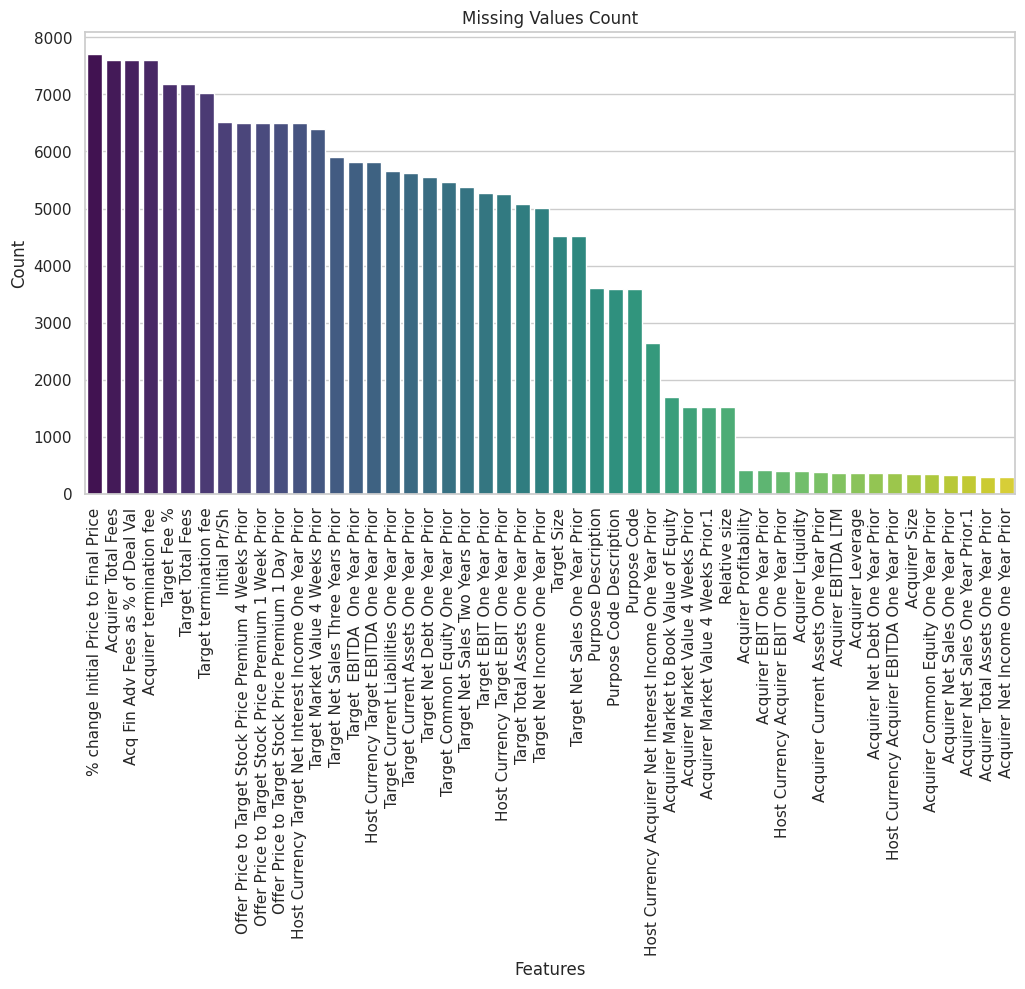

In [11]:
missing_values = df_marc.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Missing value Count Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, hue = missing_values.index, palette='viridis')
plt.xticks(rotation=90)
plt.title("Missing Values Count")
plt.xlabel("Features")
plt.ylabel("Count")
plt.show()

- 30 out of the 90 features in the dataset have over 45% missing values showing the extent of data unavailability. We don't handle these missing values directly as we are only performing exploratory analysis and aren't using any ML models.

### Univariate Numerical Columns Distributions

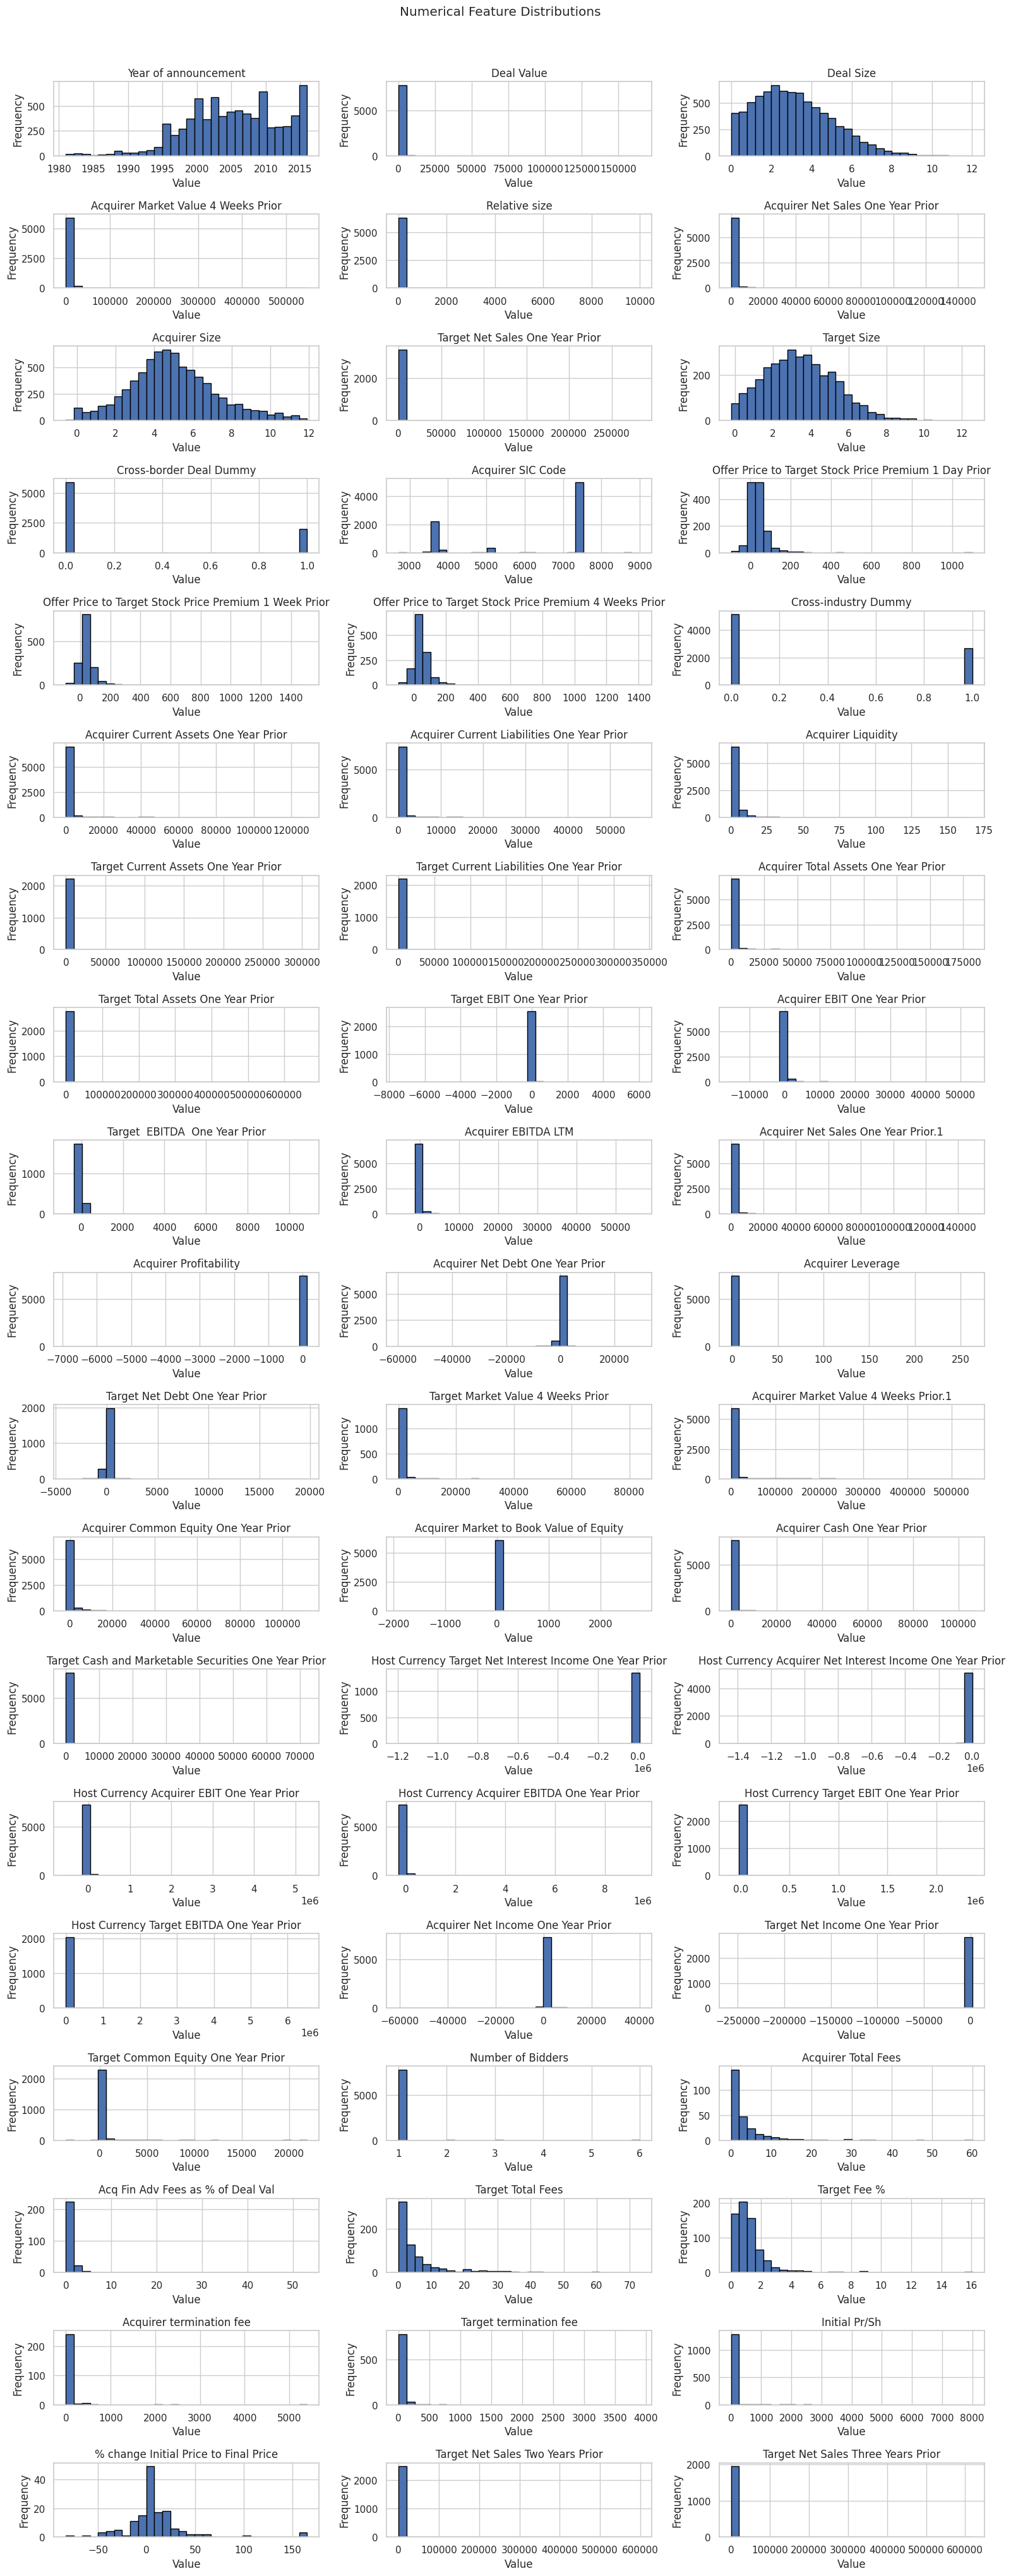

In [12]:
# Distribution of Numerical Features
fig, axes = plt.subplots(nrows=(len(num_cols)//3), ncols=3, figsize=(16, 40))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    df_marc[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.suptitle("Numerical Feature Distributions", y=1.02)
plt.show()

- Extreme outliers are present in most numerical features making the distribution plots unreadable due to only having a single dominant bar in the histogram. Hence we perform a symmetric log transformation of the data to better visualize the feature distributions.

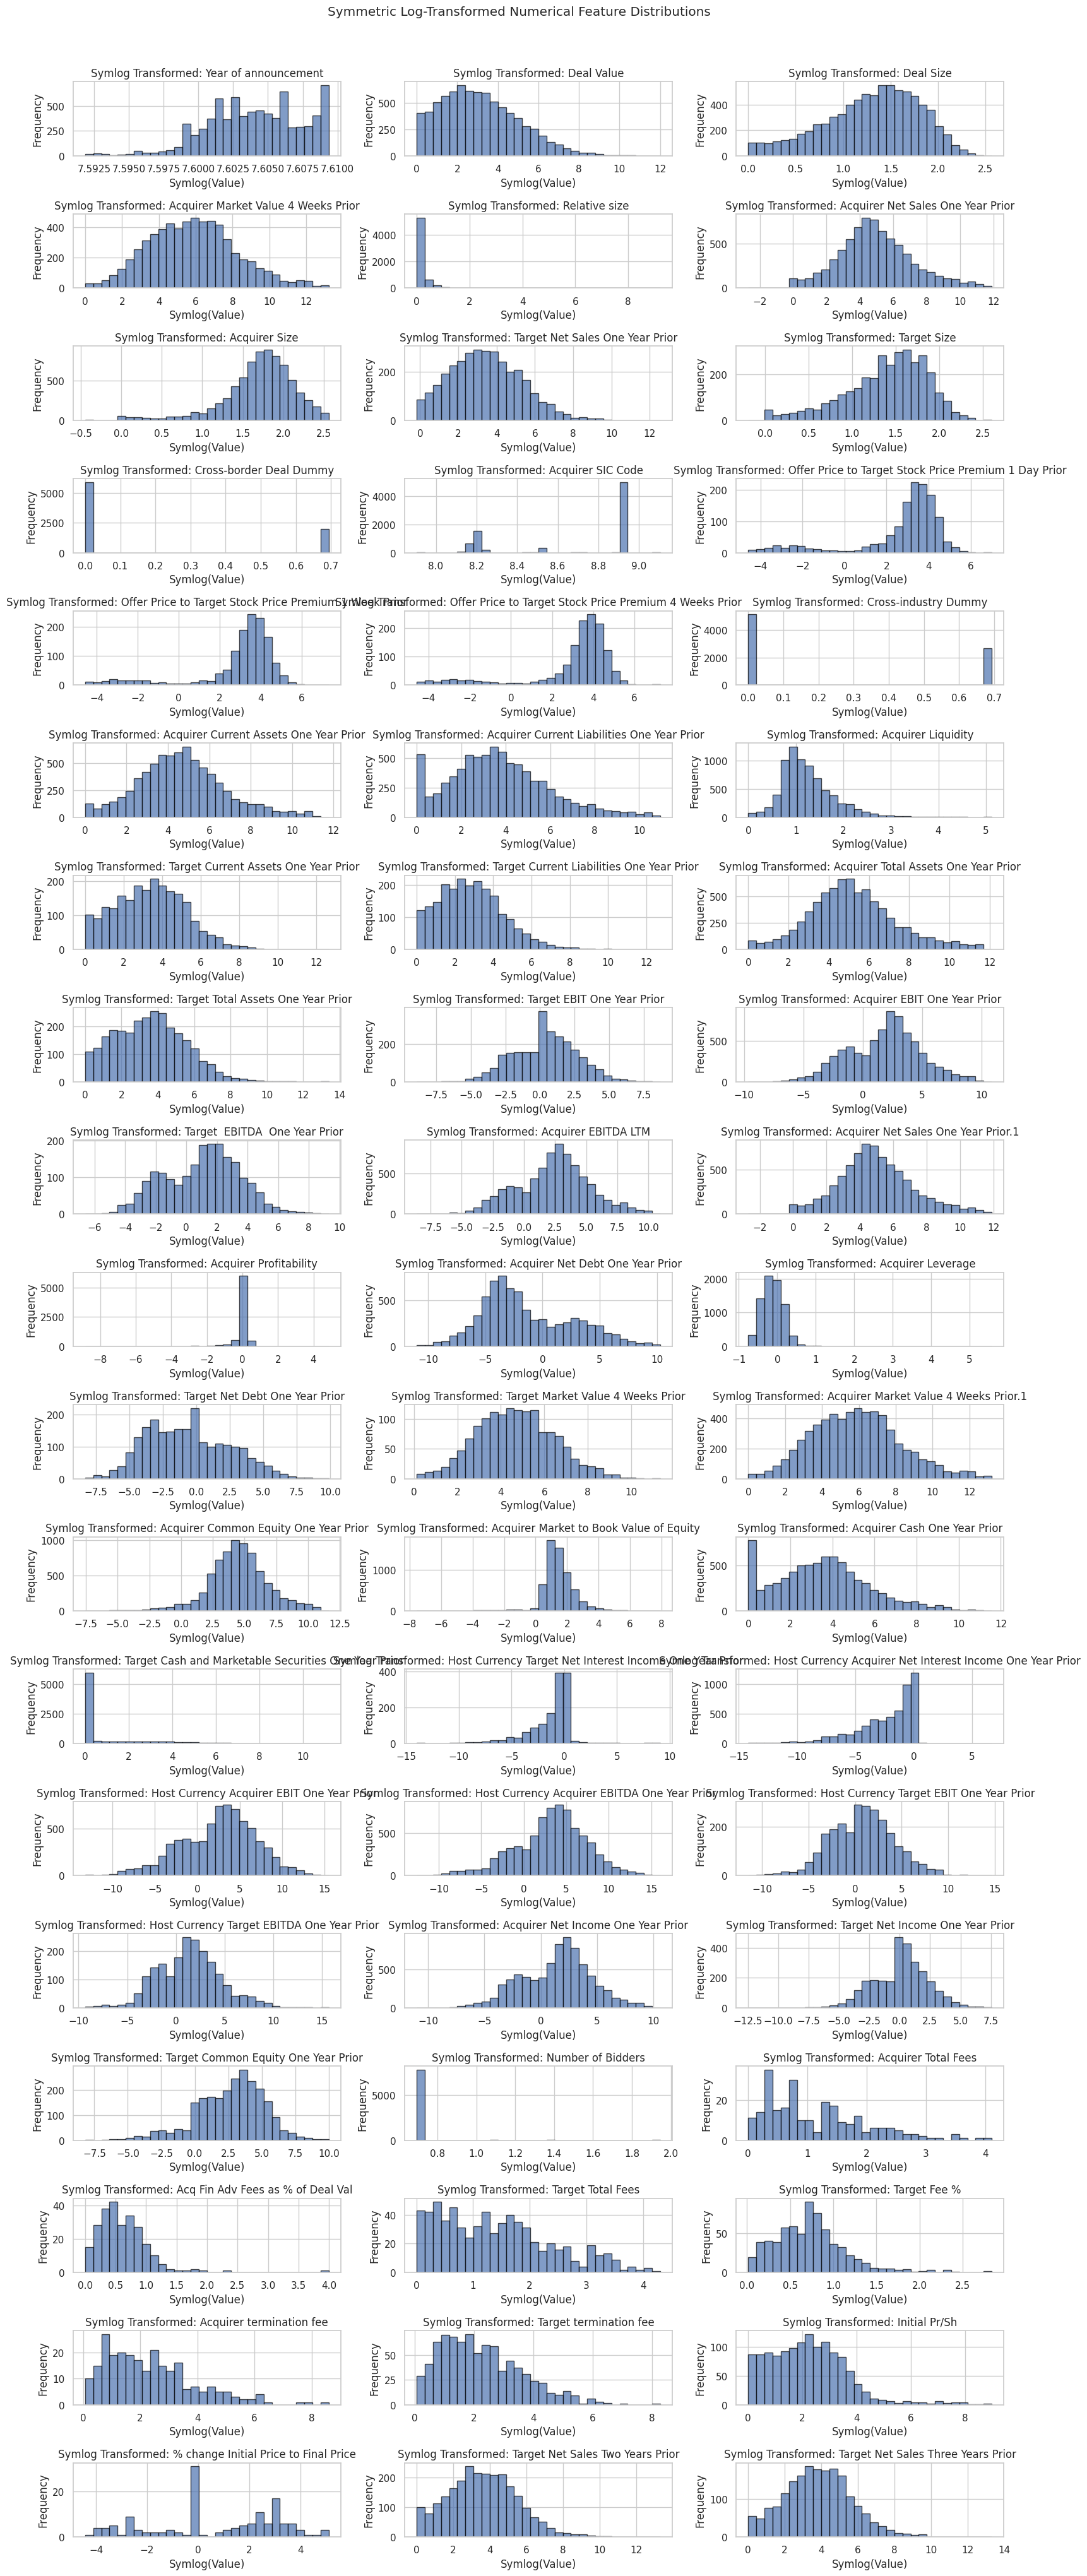

In [13]:
# Distribution of Numerical Features

def symlog_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

fig, axes = plt.subplots(nrows=(len(num_cols) // 3), ncols=3, figsize=(16, 40))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    data = df_marc[col].dropna()

    if not data.empty:  # Ensure we have data to plot
        transformed_data = symlog_transform(data)  # Apply symlog transformation
        axes[i].hist(transformed_data, bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f"Symlog Transformed: {col}")
        axes[i].set_xlabel("Symlog(Value)")
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Symmetric Log-Transformed Numerical Feature Distributions", y=1.02)
plt.show()

Observations from the symetric log transformed univariate numerical distributions visualizations:
- **Approximately Normal Looking Distributions:** Deal Size, Acquirer Market Value, Acquirer Net Sales, Target Net Sales, Acquirer Current Assets, Acquirer Total Assets, Target Market Value, Acquirer Market Value
- **Right Skewed Features:** Deal Value, Relative size, Acquirer Current Liabilities, Acquirer Liquidity, Target Current Assets, Target Current Liabilities, Target Total Assets, Acquirer Leverage, Acquirer Termination Fee, Target Termination Fee, Initial Pr/Sh
- **Left Skewed Features:** Acquirer Size, Target Size
- **Bimodal Distributions:** Offer Price to Target Stock Price Premium, Acquirer EBIT, Target EBIT, Acquirer EBITDA, Target EBITDA, Acquirer Net Debt, % change Initial to Final Price

### Univariate Categorical Countplots

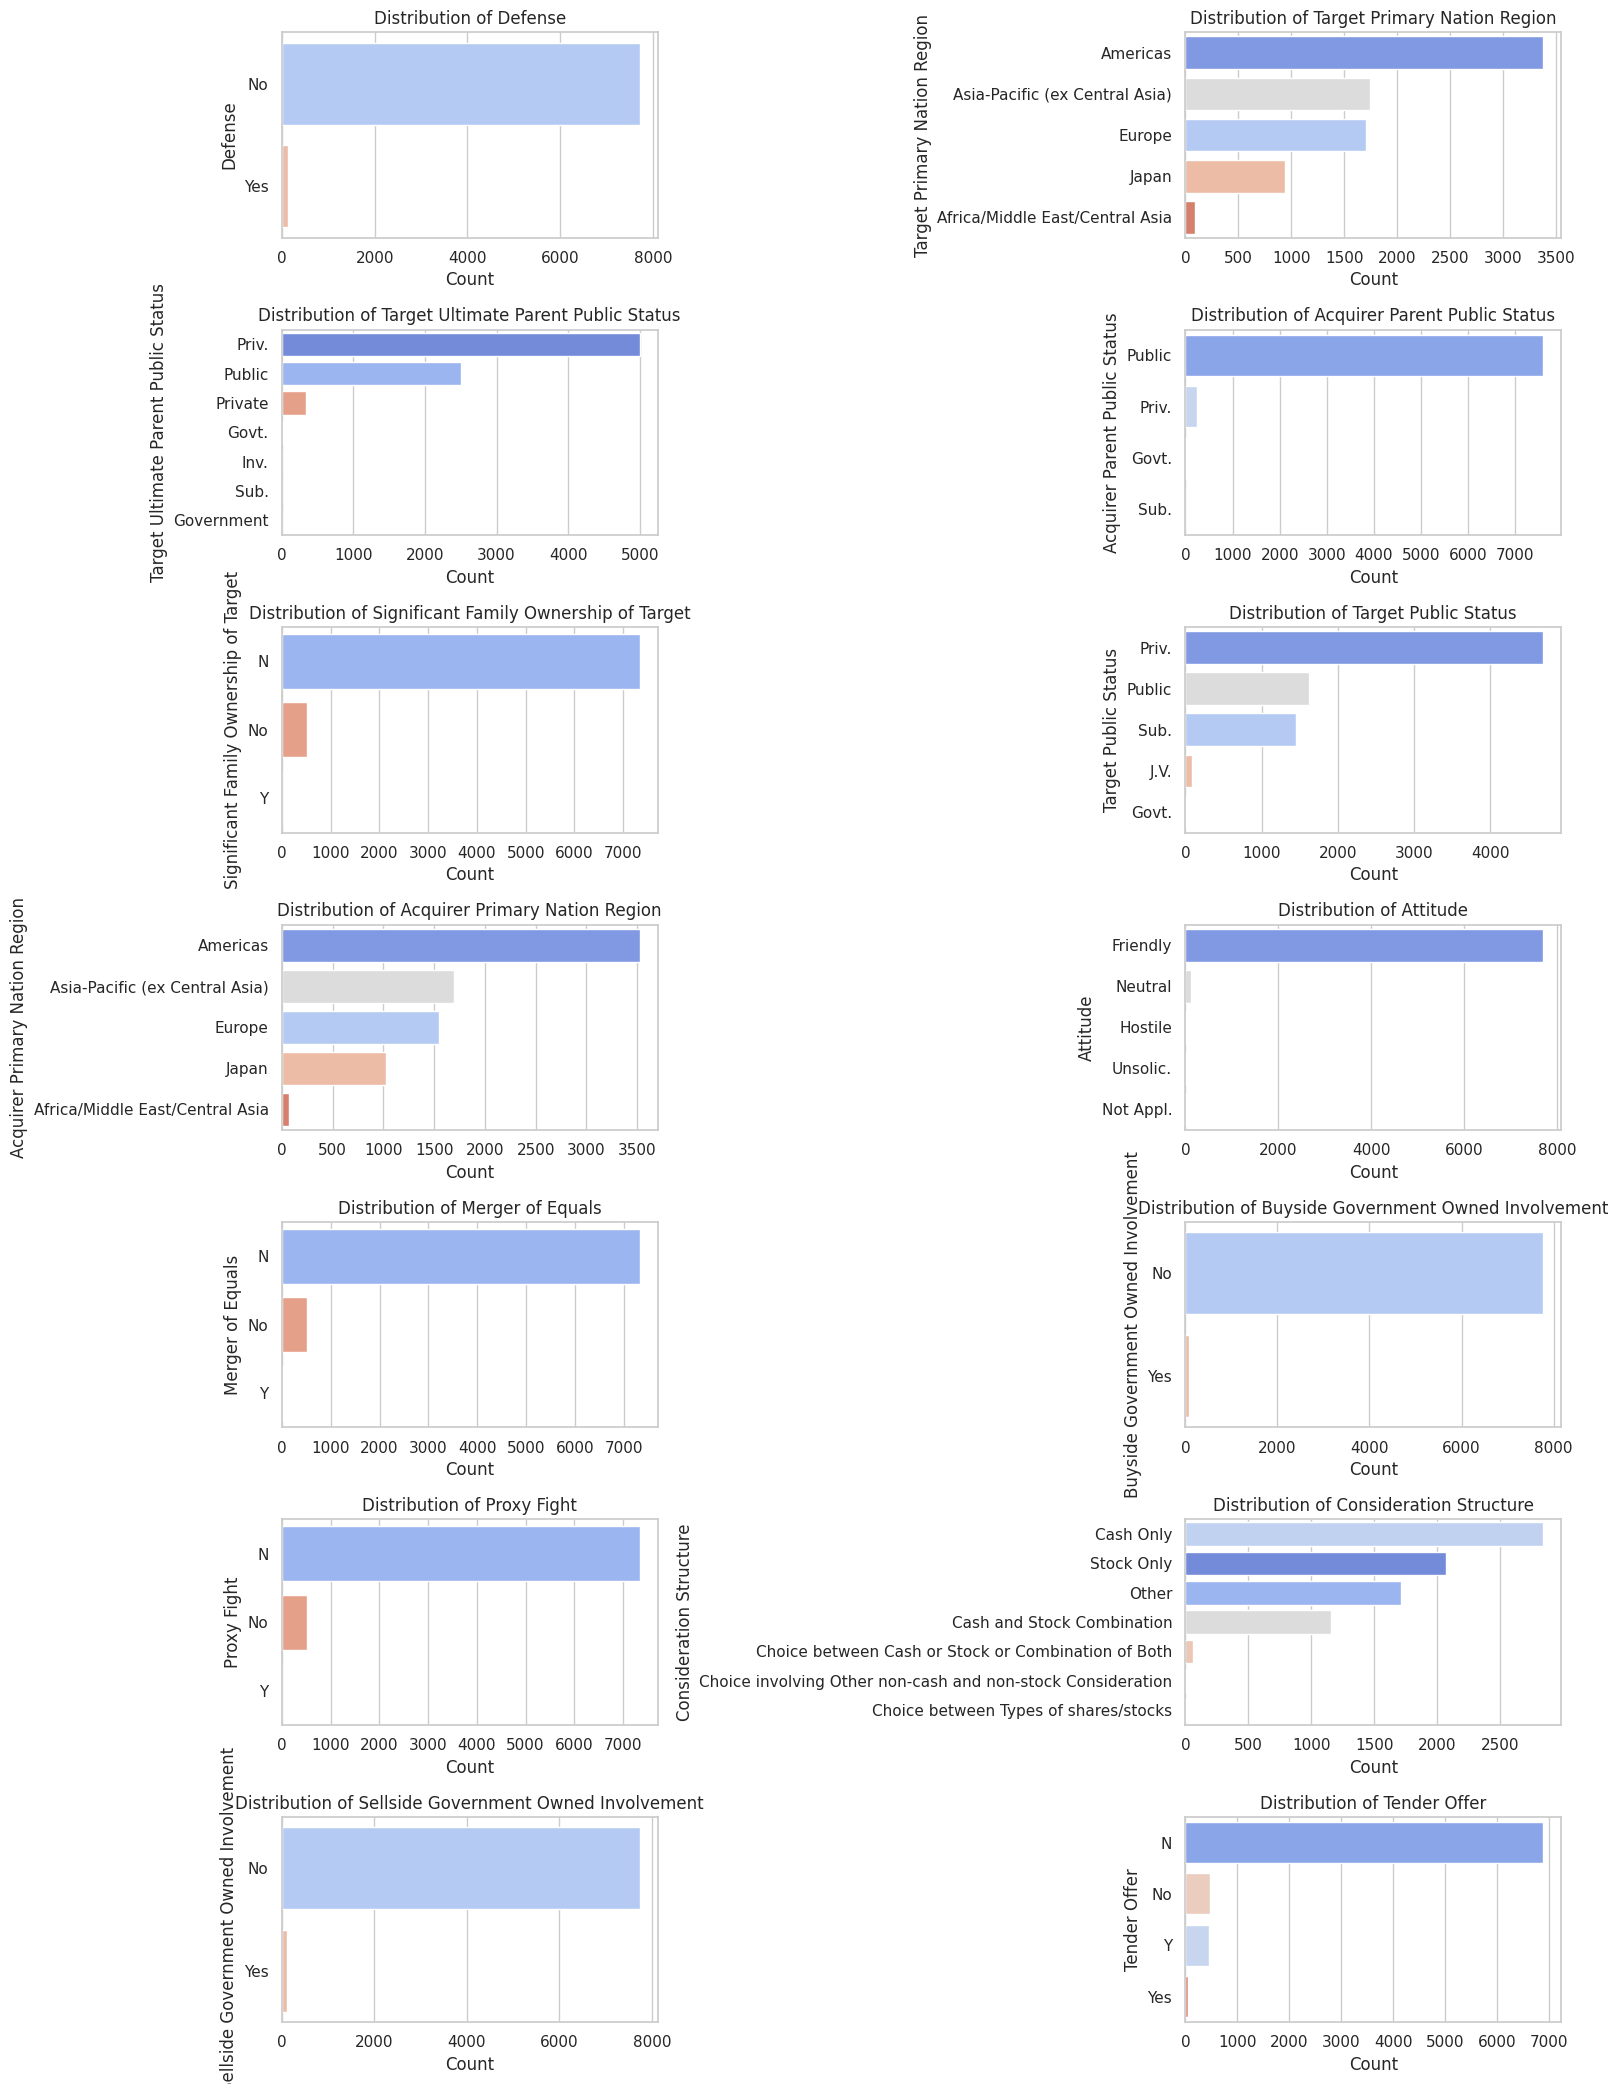

In [14]:
# Filter categorical columns with 2 to 10 unique values
filtered_cat_cols = [col for col in cat_cols if 2 <= df_marc[col].nunique() < 10]
n_rows =  (len(filtered_cat_cols) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, n_rows * 3))

axes = axes.flatten()

for i, col in enumerate(filtered_cat_cols):
    sns.countplot(ax=axes[i], y=df_marc[col], order=df_marc[col].value_counts().index, hue=df_marc[col], palette='coolwarm', legend=False)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Though the categorical countplots are easier to read, the observations from the categorical summary table and categorical countplots are similar.

### Bivariate Analysis

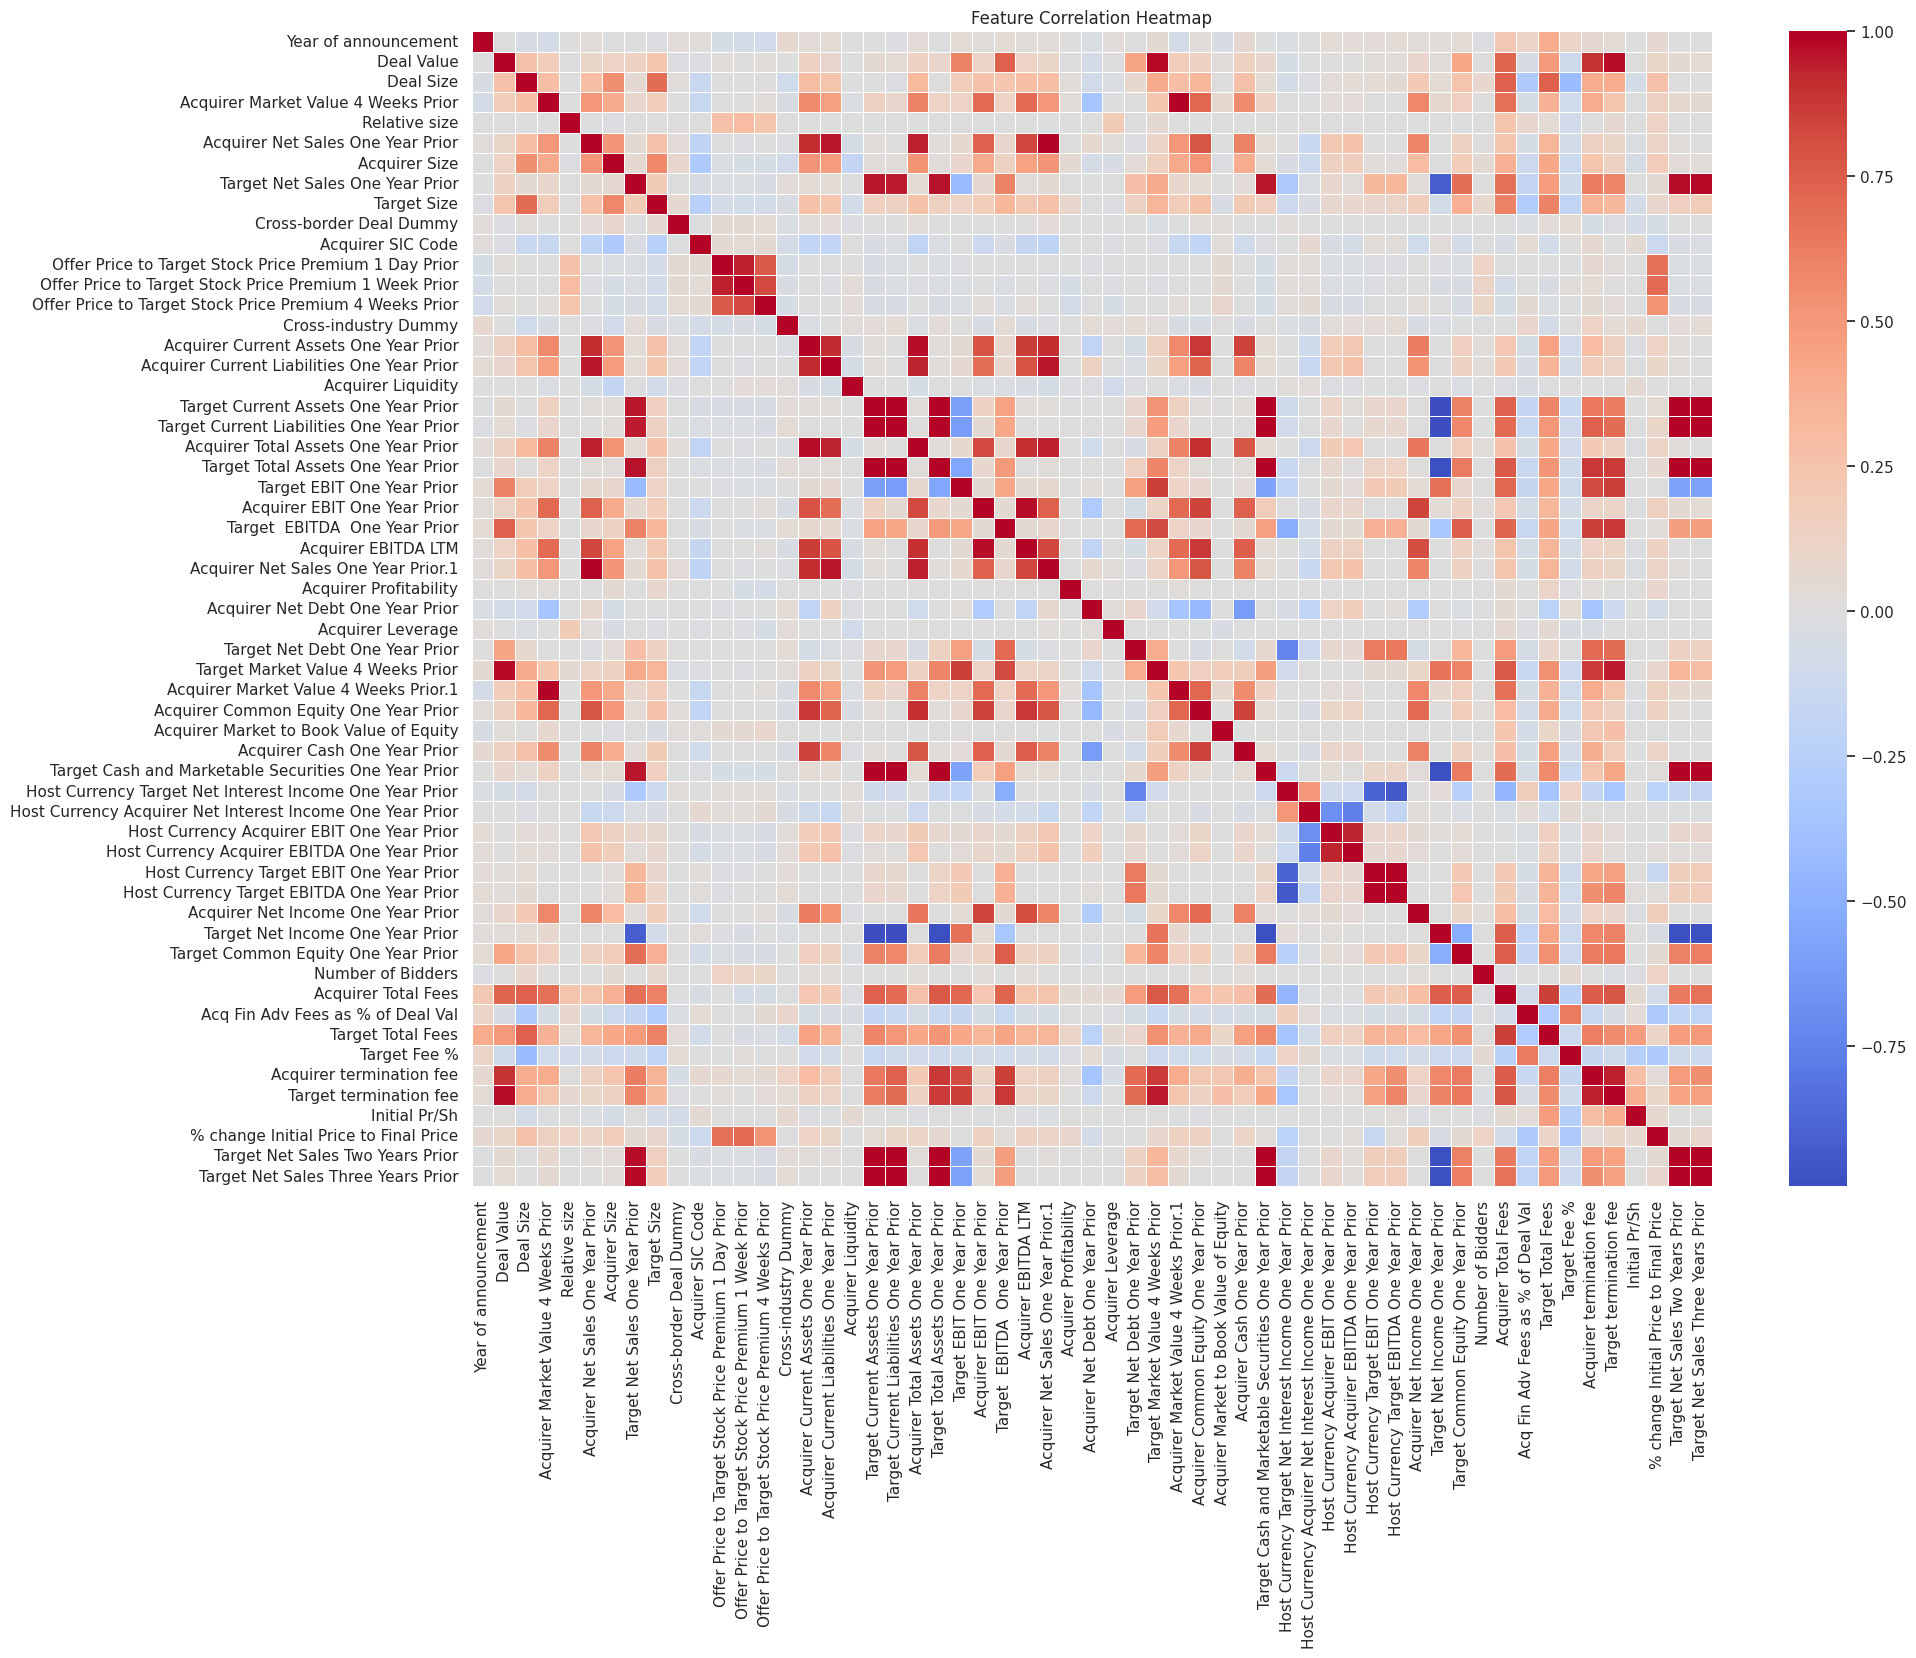

In [15]:
# Correlation Heatmap (For Numerical Features)

plt.figure(figsize=(20, 15))
corr_matrix = df_marc[num_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

- While most features are uncorrelated with each other, some features show extreme correlations (both positive and negative). Upon closer examination, it can be observed that these are derived features from the other columns explaining the strong correlations.

### Important Multi-Variate Visualizations

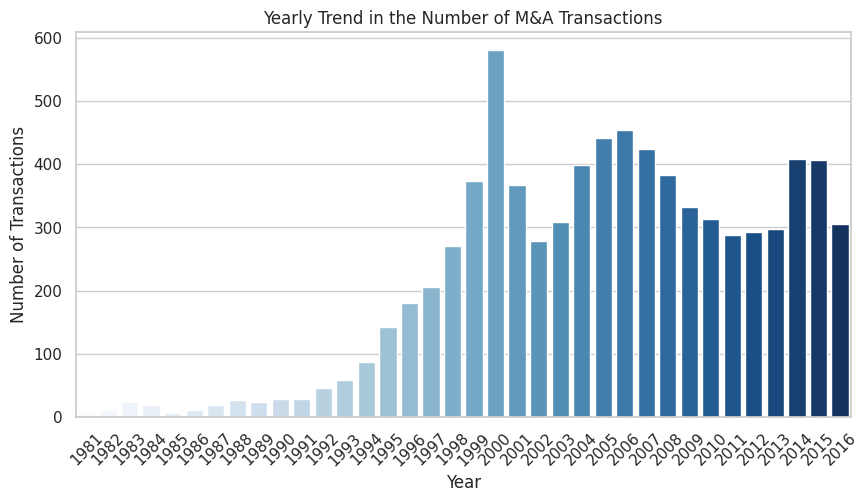

In [16]:
# Yearly trend in the number of transactions

plt.figure(figsize=(10, 5))
sns.countplot(data=df_marc, x="Year of announcement", hue=df_marc["Year of announcement"], palette="Blues", order=sorted(df_marc["Year of announcement"].unique()), legend = False)
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.title("Yearly Trend in the Number of M&A Transactions")
plt.xticks(rotation=45)
plt.show()

- There is a notable increase in the number of successful M&A transactions in the tech sector over time.
- The number of transactions increased monotonically from 1981 to 2000, peaking in the year 2000 with 600 transactions in that year.
- After the year 2000, the number of transactions oscillated in the range of 250 to 450.
- It is interesting to note that the peaks in the number of Mergers and Acquisitions correspond to years of financial crises, such as 2000s dot-com bubble, 2007 Great Financial Crisis, and 2015-16 Stock Market Selloff.

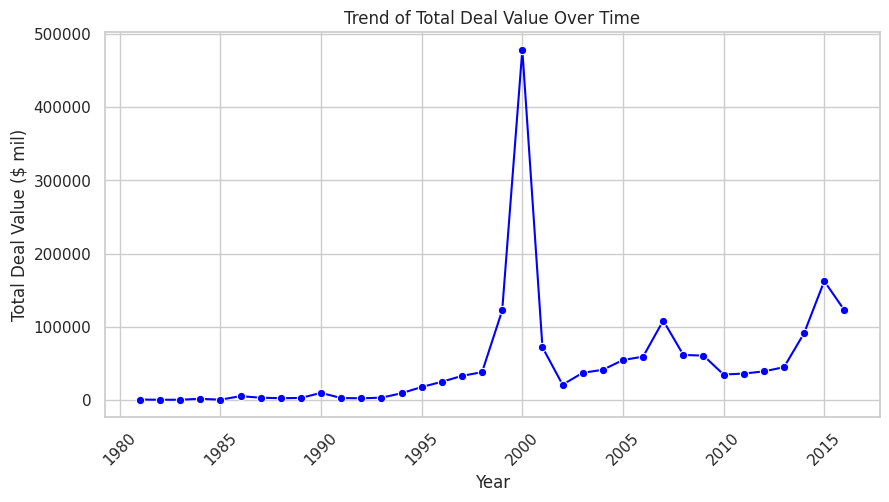

In [17]:
# Trend of total deal value over time

deal_value_per_year = df_marc.groupby("Year of announcement")["Deal Value"].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=deal_value_per_year, x="Year of announcement", y="Deal Value", marker="o", color="blue")
plt.xlabel("Year")
plt.ylabel("Total Deal Value ($ mil)")
plt.title("Trend of Total Deal Value Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- The total deal value has an increasing trend peaking again in the year 2000.
- The trendline of the total deal value shows similar peaks and troughs as the number of transactions trend.

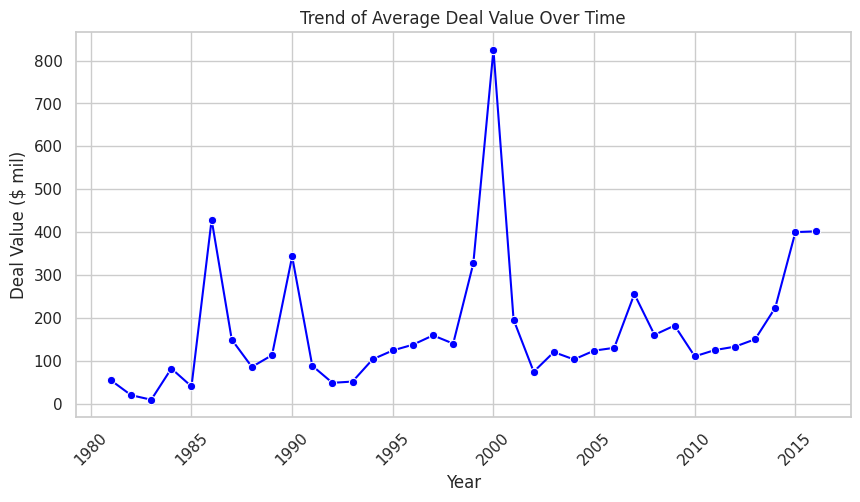

In [18]:
# Trend of average deal value over time

avg_deal_value_per_year = df_marc.groupby("Year of announcement")["Deal Value"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_deal_value_per_year, x="Year of announcement", y="Deal Value", marker="o", color="blue")
plt.xlabel("Year")
plt.ylabel("Deal Value ($ mil)")
plt.title("Trend of Average Deal Value Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- The average deal value over time plot still shows a peak in the year 2000 indicating that the peak in total deal value plot isn't necessarily due to the volume of transactions alone.
- There are local maxima in average deal value in the years 1986, 1990 and 2015.

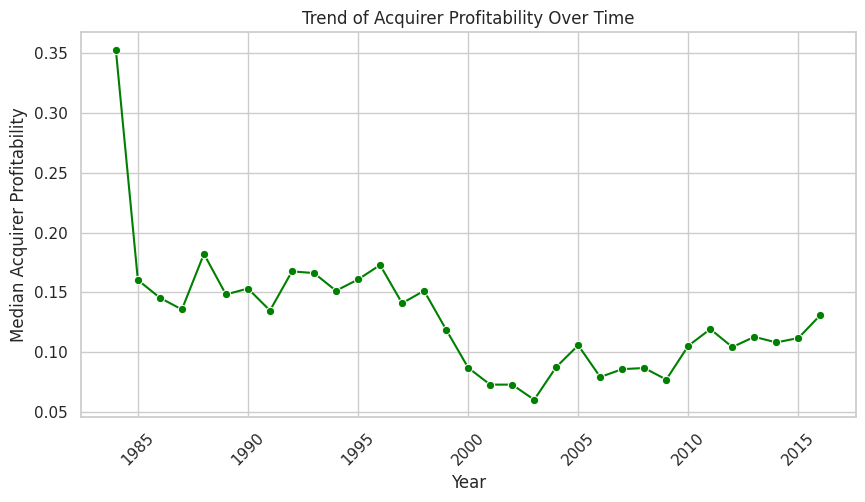

In [19]:
# Trend of Acquirer profitability

profitability_trend = df_marc.groupby("Year of announcement")["Acquirer Profitability"].median().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=profitability_trend, x="Year of announcement", y="Acquirer Profitability", marker="o", color="green")
plt.xlabel("Year")
plt.ylabel("Median Acquirer Profitability")
plt.title("Trend of Acquirer Profitability Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- The Median Acquirer Profitability is positive during the entire period though numerical summary statistics showed a negative mean.
- There is a decline in Acquirer Profitability over the years with the lowest value being observed in 2003.

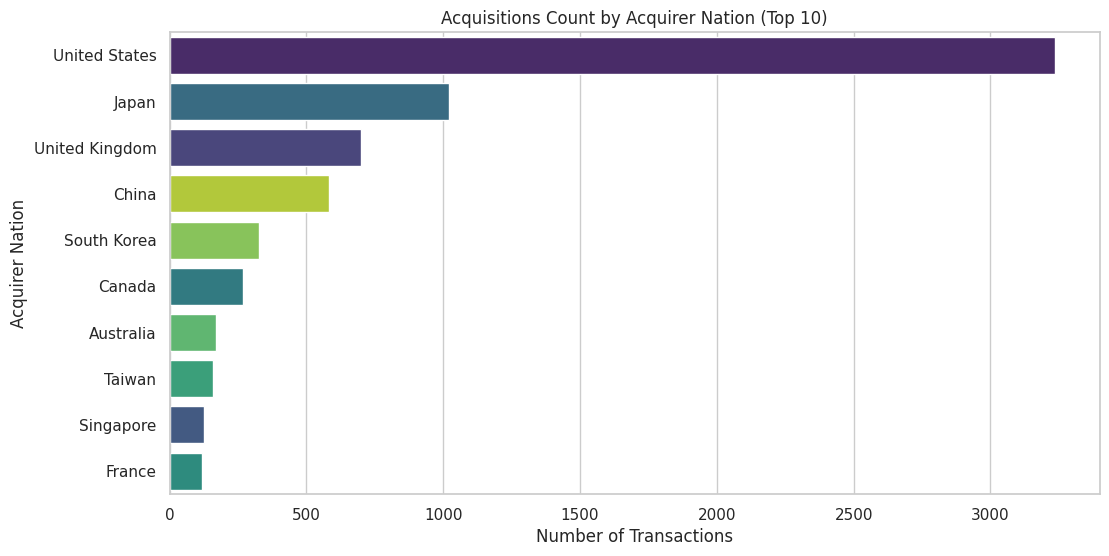

In [20]:
# Acquisitions Count by Acquirer Nation

top_countries = df_marc["Acquirer Nation"].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.countplot(data=df_marc[df_marc["Acquirer Nation"].isin(top_countries)], y="Acquirer Nation", order=top_countries, hue = "Acquirer Nation", palette="viridis")
plt.xlabel("Number of Transactions")
plt.ylabel("Acquirer Nation")
plt.title("Acquisitions Count by Acquirer Nation (Top 10)")
plt.show()

- The United States is the most common Acquirer Nation followed by Japan, UK and China.
- The United States has more successful transactions than the next three nations combined.

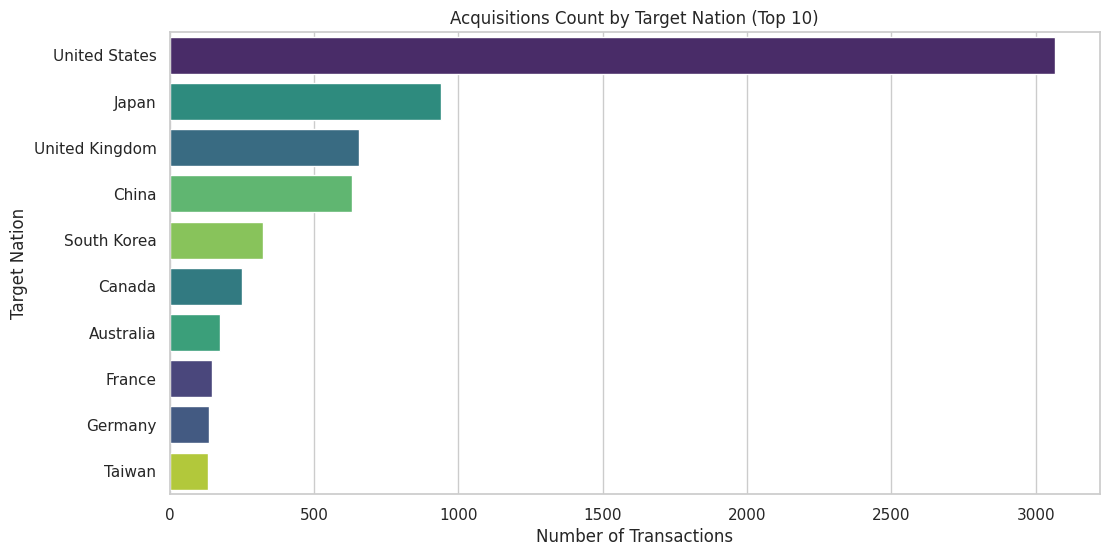

In [21]:
# Acquisitions Count by Target Nation

top_countries = df_marc["Target Nation"].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.countplot(data=df_marc[df_marc["Target Nation"].isin(top_countries)], y="Target Nation", order=top_countries, hue = "Target Nation", palette="viridis")
plt.xlabel("Number of Transactions")
plt.ylabel("Target Nation")
plt.title("Acquisitions Count by Target Nation (Top 10)")
plt.show()

- The United States is also the most common Target Nation.
- The next three countries include Japan, UK and China, similar to the Acquirer Nations' trend.

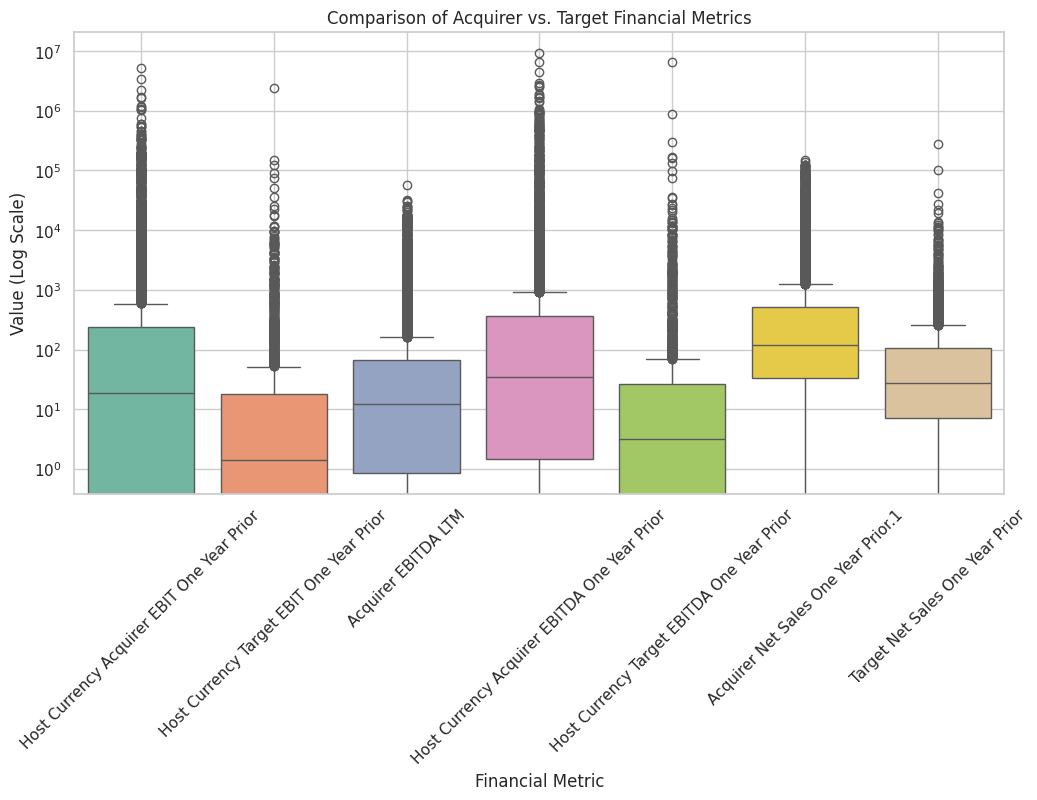

In [22]:
# Acquirer vs. target EBIT, EBITDA, and Net Sales (side-by-side boxplots)

metrics = ["Host Currency Acquirer EBIT One Year Prior", "Host Currency Target EBIT One Year Prior",
           "Acquirer EBITDA LTM", "Host Currency Acquirer EBITDA One Year Prior", "Host Currency Target EBITDA One Year Prior",
           "Acquirer Net Sales One Year Prior.1", "Target Net Sales One Year Prior"]

df_melted = df_marc.melt(value_vars=metrics, var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Metric", y="Value", hue="Metric", palette="Set2")
plt.xticks(rotation=45)
plt.yscale("log")  # Using log scale for better visualization
plt.xlabel("Financial Metric")
plt.ylabel("Value (Log Scale)")
plt.title("Comparison of Acquirer vs. Target Financial Metrics")
plt.grid(True)
plt.show()

- The comparitive box-plot containing Acquirer vs. target EBIT, EBITDA, and Net Sales show that both the median values and the entire distributions for each of these metrics is greater for the Acquirer than the corresponding value for the Target.
- This shows how the Acquirers on average are consistently better performing than the Targets, especially with respect to EBIT (Earnings Before Interest and Taxes), EBITDA (Earnings Before Interest, Taxes, Depreciation, and Amortization), and Net Sales.

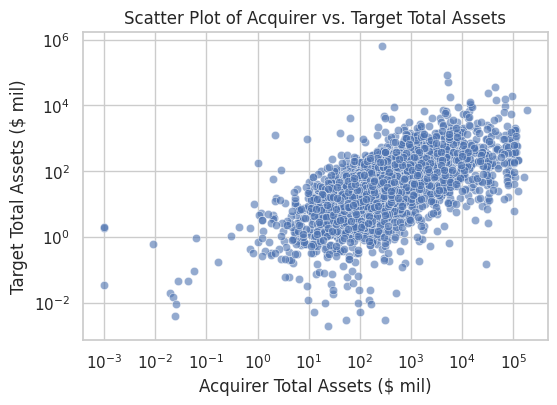

In [23]:
# Acquirer vs. target total assets

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_marc, x="Acquirer Total Assets One Year Prior", y="Target Total Assets One Year Prior", alpha=0.6)
plt.xlabel("Acquirer Total Assets ($ mil)")
plt.ylabel("Target Total Assets ($ mil)")
plt.title("Scatter Plot of Acquirer vs. Target Total Assets")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

- The scatter plot between the total assets of the Acquirer vs. the Target companies show a positive correltion.
- It can be observed that acquirers with higher values of total assets on average prefer targets with higher values of total assets.
- It is interesting to note that there are transactions where the value of the total assets of the Acquirer is lower than that of their Target.

### Conclusions

1. Dataset Overview & Preprocessing:
  - The dataset contains 90 features related to successful M&A transactions in the tech sector, including financial metrics, categorical attributes, and dates.
  - Duplicate rows (424) were dropped to ensure data quality.
  - Data Types Distribution:
    - 57 Numerical Features (financial metrics).
    - 31 Categorical Features (company & transaction details).
    - 2 Datetime Features (announcement & effective dates).
  - Missing Values:
    - 30 features have over 45% missing values, highlighting data unavailability.
    - Since we are not using machine learning, high null percentage columns were neither dropped nor were missing values imputed.
2. Key Financial Insights from Statistical Summaries:
  - Deal Value is highly variable, averaging 229M USD, with outliers up to 165B USD.
  - Acquirer Market Value is similarly skewed, with a median of 322M USD but reaching 547B USD.
  - Relative Size (Deal Size / Acquirer Market Value) is usually small (median = 0.07) but can be 10,000x in extreme cases.
  - Acquirers tend to be significantly larger than targets across all financial metrics (Net Sales, Total Assets, EBIT, EBITDA).
  - 25% of transactions are cross-border, and 34% are cross-industry, indicating a strong preference for domestic, within-sector acquisitions.
  - Acquirer profitability is mostly negative, but leverage remains relatively low on average.
3. Categorical Feature Insights
  - 47 Unique Acquirer Nations—United States dominates as both the most common acquirer and target nation.
  - Most deals are NOT mergers of equals, and tender offers (hostile takeovers) are rare.
  - Most acquisitions are Friendly, with government involvement being rare.
  - The most common purpose of acquisitions is to “Strengthen Operations”.
  - All acquirers in the dataset are public, while most targets are private, confirming the trend that larger public firms acquire smaller private firms.
  - Proxy fights were rare, and defensive tactics were used occasionally (14 types recorded).
4. Univariate Numerical Distributions (After Symmetric Log Transformation)
  - Approximately Normal: Deal Size, Acquirer Market Value, Acquirer Net Sales, Target Net Sales, Total Assets.
  - Right Skewed (Highly Asymmetric): Deal Value, Relative Size, Acquirer Liquidity, Acquirer Leverage, Termination Fees.
  - Left Skewed (Negative Bias): Acquirer Size, Target Size.
  - Bimodal Distributions: Offer Price Premium, Acquirer & Target EBIT/EBITDA, Acquirer Net Debt, % Change in Initial to Final Price.
  - Extreme outliers made raw histograms unreadable, necessitating log transformations.
5. Correlations & Derived Features
  - Most features are uncorrelated, except for derived financial metrics (e.g., Net Sales & Profitability).
  - Some extreme correlations exist, mainly due to calculations based on other columns.
6. Trends in M&A Activity Over Time
  - Number of M&A transactions increased significantly over time, peaking in 2000 (~600 deals).
  - Transactions fluctuated between 250-450 per year post-2000, correlating with financial crises (Dot-com Bubble, 2008 Crisis, 2015-16 Market Selloff).
  - Total deal value follows a similar pattern, peaking in 2000, indicating higher transaction activity during economic downturns.
  - Average deal value also peaked in 2000, confirming that the high total deal value was not just due to volume but also larger deals.
  - Acquirer Profitability has declined over time, hitting its lowest in 2003, yet the median remains positive.
7. Geographical Insights
  - United States leads in both Acquisitions & Targets, with more deals than Japan, UK, and China combined.
  - Cross-border transactions are limited, reinforcing the dominance of domestic deals.
8. Financial Comparisons Between Acquirers & Targets
  - Acquirer vs. Target EBIT, EBITDA, and Net Sales:
    - Acquirers consistently outperform targets in these metrics.
    - Targets tend to be smaller and less profitable, reinforcing the idea that M&As help smaller firms grow under larger organizations.
  - Acquirer vs. Target Total Assets:
    - Positive correlation—larger acquirers tend to target firms with higher total assets.
    - However, some deals involve targets with larger total assets than their acquirers, suggesting strategic acquisitions beyond just financial size.


## Crunchbase Dataset

The data dictionary for the Crunchbase dataset can be found in our GitHub repository [linked here](https://github.com/d33ksh2/MScFE_7849_Capstone/blob/main/Data/DataDictionary_Crunchbase_Dataset.md).

In [24]:
print("The shape of the Crunchbase DataFrame is:", df_crunchbase.shape)
print("\nColumn info of the Crunchbase Dataframe is:")
print(df_crunchbase.info())

The shape of the Crunchbase DataFrame is: (31984, 18)

Column info of the Crunchbase Dataframe is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            31752 non-null  object 
 1   category_code         30507 non-null  object 
 2   country_code          31984 non-null  object 
 3   state_code            31984 non-null  object 
 4   average_funded        28104 non-null  float64
 5   total_rounds          31984 non-null  int64  
 6   average_participants  31984 non-null  float64
 7   products_number       4043 non-null   float64
 8   offices               29607 non-null  float64
 9   acquired_companies    1529 non-null   float64
 10  mba_degree            8095 non-null   float64
 11  phd_degree            2741 non-null   float64
 12  ms_degree             6056 non-null   float64
 13  other_degree          

- The Crunchbase dataset contains ~32k rows and 18 columns with a mixture of categorical, numerical and boolean features.
- Several columns have high missing values. `acquired_companies`, `products_number` and degree-related fields are some of them.

In [25]:
# Checking for data imbalance

print("Proportions of mergers and non-mergers in the dataset are:")
print(df_crunchbase.is_acquired.value_counts(normalize=True)*100)

Proportions of mergers and non-mergers in the dataset are:
is_acquired
False    91.770885
True      8.229115
Name: proportion, dtype: float64


- Only 8.23% of companies in the dataset were actually acquired, making it a highly imbalanced dataset.

In [26]:
# Creating a DataFrame containing count and percent of null-values
df_crunchbase_stats = pd.DataFrame({
    'Missing Percent (%)': round(100 * df_crunchbase.isnull().mean(), 2),
    'Missing Count (#)': df_crunchbase.isnull().sum()
})
# Sort the DataFrame by the Missing Percentage in descending order
df_crunchbase_stats = df_crunchbase_stats.sort_values(by='Missing Count (#)', ascending=False)
display(df_crunchbase_stats)

Missing Percent (%)  Missing Count (#)
acquired_companies                  95.22              30455
phd_degree                          91.43              29243
products_number                     87.36              27941
ms_degree                           81.07              25928
mba_degree                          74.69              23889
other_degree                        52.09              16661
age                                 23.38               7479
average_funded                      12.13               3880
offices                              7.43               2377
category_code                        4.62               1477
company_id                           0.73                232
average_participants                 0.00                  0
total_rounds                         0.00                  0
state_code                           0.00                  0
country_code                         0.00                  0
ipo                                  0.00                  0
is_acquired                          0.00                  0
is_closed                            0.00                  0

In [27]:
# Numerical Summary Statistics

numerical_cols = df_crunchbase.select_dtypes(include=['number'])
numerical_summary = numerical_cols.describe()
display(numerical_summary)

average_funded  total_rounds  average_participants  products_number  \
count    2.810400e+04  31984.000000          31984.000000      4043.000000   
mean     8.121171e+06      1.657641              1.376677         2.172149   
std      4.445384e+07      1.199605              1.754006         2.848395   
min      2.910000e+02      1.000000              0.000000         1.000000   
25%      4.640000e+05      1.000000              0.000000         1.000000   
50%      1.965732e+06      1.000000              1.000000         1.000000   
75%      6.705533e+06      2.000000              2.000000         2.000000   
max      3.822518e+09     15.000000             36.000000        91.000000   

            offices  acquired_companies   mba_degree   phd_degree  \
count  29607.000000         1529.000000  8095.000000  2741.000000   
mean       1.164522            2.347286     2.399629     1.792412   
std        0.744763            7.139714     4.586163     2.205243   
min        1.000000            1.000000     1.000000     1.000000   
25%        1.000000            1.000000     1.000000     1.000000   
50%        1.000000            1.000000     1.000000     1.000000   
75%        1.000000            2.000000     3.000000     2.000000   
max       67.000000          159.000000   207.000000    60.000000   

         ms_degree  other_degree           age  
count  6056.000000  15323.000000  24505.000000  
mean      2.050363      5.381844   2536.630769  
std       4.205058     14.778870   2485.813094  
min       1.000000      1.000000      0.000000  
25%       1.000000      1.000000   1096.000000  
50%       1.000000      3.000000   1826.000000  
75%       2.000000      6.000000   3287.000000  
max     196.000000    974.000000  40543.000000

Key insights from the numerical summary statics:
- Funding amount is highly skewed. Mean funding is 8.12M USD but 75% of companies received ≤ 6.70M USD.
- Most companies have only 1 funding round The median number of rounds is 1, 75th Percentile <= 2 but the maximum value is 15.
- Team size varies widely with median equalling 1 but the max value being 36.
- Few companies have multiple products. The median number of products is 1, 75th Percentile <= 2 but the maximum value is 91.
- The number of offices is usually 1 (75th percentile is 1) but some have many offices (max = 67 offices).
- Number of acquired companies ranges from 1 to 159 with most companies having less than or equal to 2 acquisitions.
- Education background shows high variability with median values for number of MBA, PhD and MS graduate employees being 1 but the maximum values being 207, 60 and 196 respectively.
- The median age of a company is ~5 yrats and 75% of the companies are less than or equal to 9 years old. But the oldest company is 111 years old.


In [28]:
# Categorical Summary Statistics

categorical_cols = df_crunchbase.select_dtypes(include=['object', 'bool'])
categorical_summary = categorical_cols.describe()
display(categorical_summary)

company_id category_code country_code state_code    ipo is_acquired  \
count       31752         30507        31984      31984  31984       31984   
unique      31702            42            3          2      2           2   
top       c:44268      software          USA      other  False       False   
freq            3          4677        19768      24645  31666       29352   

       is_closed  
count      31984  
unique         2  
top        False  
freq       29888

Key insights from the Categorical Summary Table:

- There are 42 unique industries with "Software" being the top category.
- Over 60% of the cmpanies are from USA. And over 20% of the companies are based in California.
- Very few companies (~300 out of around 32k) went public with an IPO.
- Most companies are not acquired or closed.

### Univariate Analysis

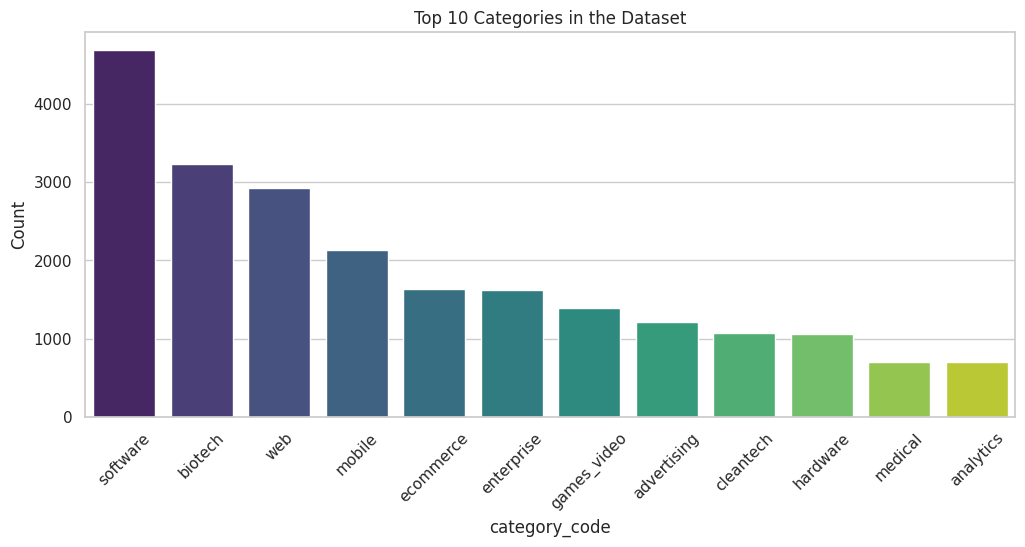

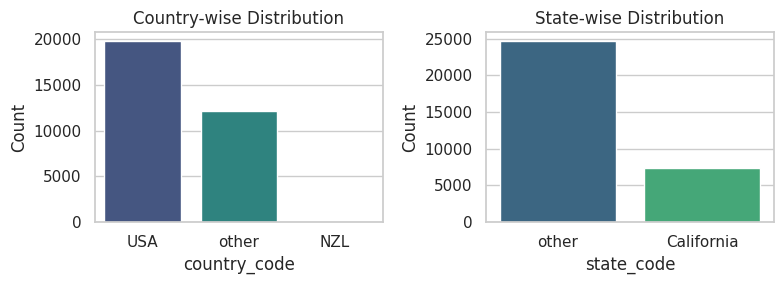

In [29]:
# Distribution of Categorical Variables

# Top 12 Categories
plt.figure(figsize=(12, 5))
top_categories = df_crunchbase["category_code"].value_counts().nlargest(12)  # Top 12
sns.barplot(x=top_categories.index, y=top_categories.values, hue=top_categories.index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Categories in the Dataset")
plt.xlabel("category_code")
plt.ylabel("Count")
plt.show()

print("\n")

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# Country-wise Distribution
top_countries = df_crunchbase["country_code"].value_counts().nlargest(10)
sns.barplot(ax=axes[0], x=top_countries.index, y=top_countries.values, hue = top_countries.index, palette="viridis")
axes[0].set_xticks(top_countries.index)
axes[0].set_title("Country-wise Distribution")
axes[0].set_xlabel("country_code")
axes[0].set_ylabel("Count")

# State-wise Distribution
top_states = df_crunchbase["state_code"].value_counts().nlargest(10)
sns.barplot(ax=axes[1], x=top_states.index, y=top_states.values, hue = top_states.index, palette="viridis")
axes[1].set_xticks(top_states.index)
axes[1].set_title("State-wise Distribution")
axes[1].set_xlabel("state_code")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


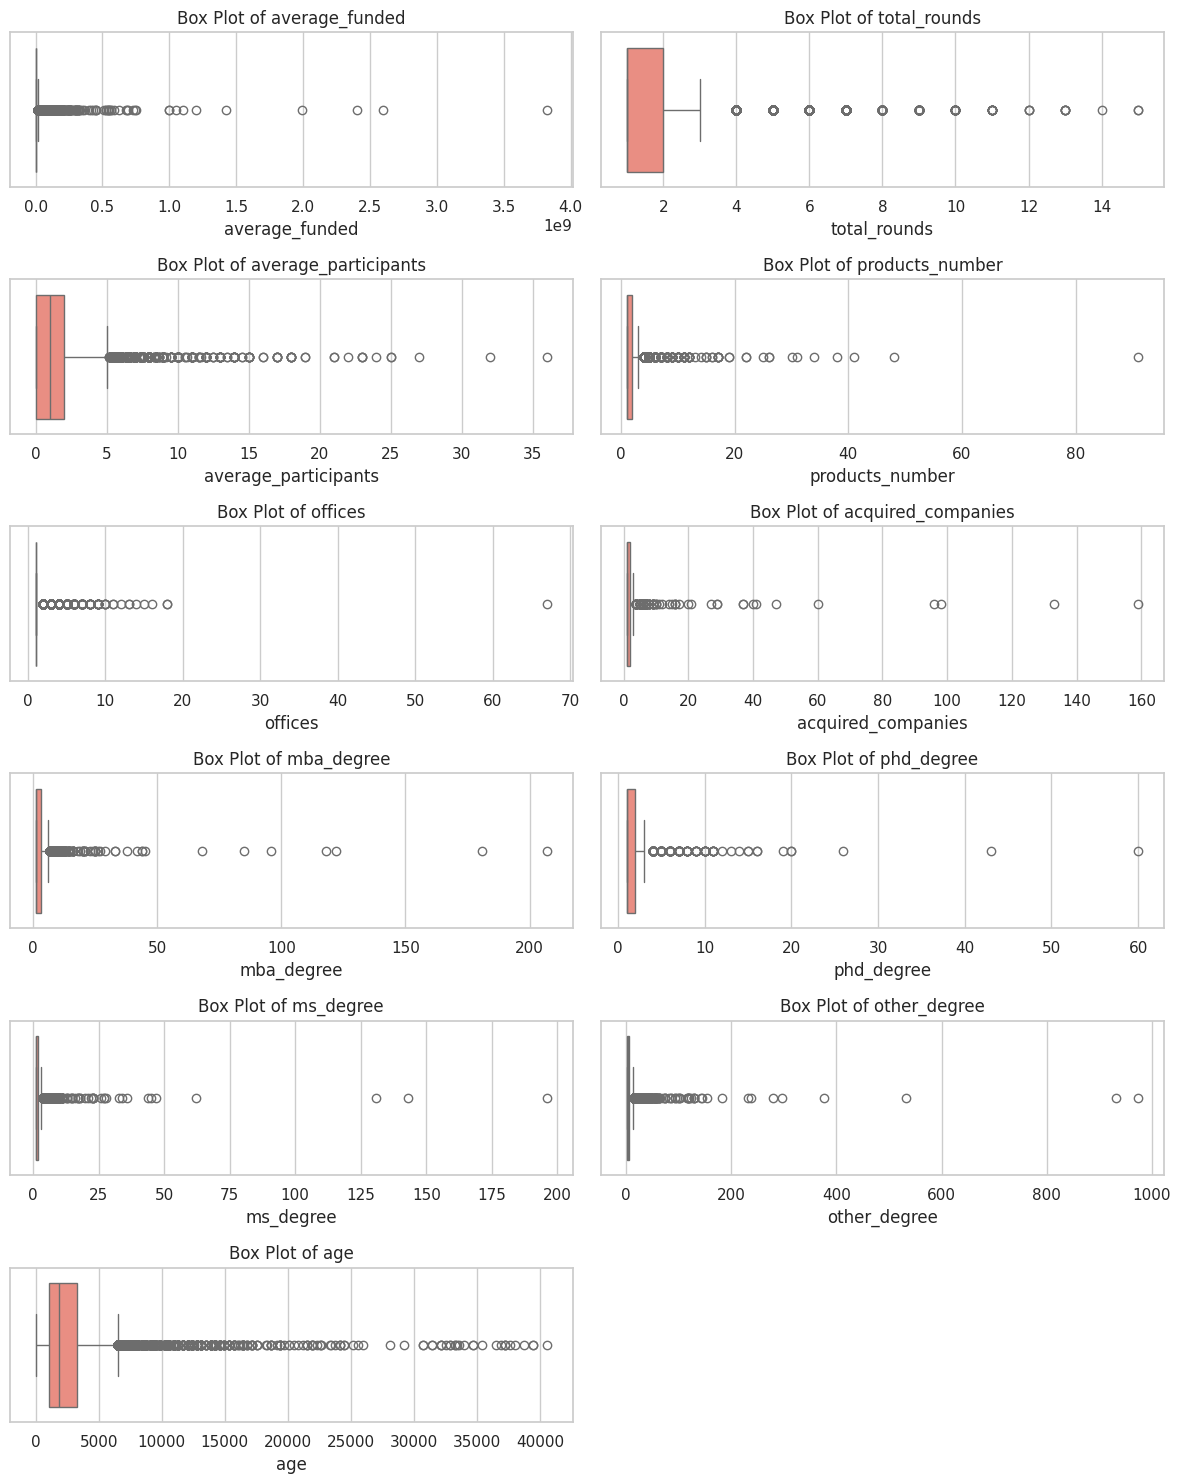

In [30]:
# 3. Distribution of Numerical Variables
numerical_cols = ["average_funded", "total_rounds", "average_participants",
                  "products_number", "offices", "acquired_companies",
                  "mba_degree", "phd_degree", "ms_degree", "other_degree", "age"]

fig, axes = plt.subplots(6, 2, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(ax=axes[i], x=df_crunchbase[col], color="salmon")
    axes[i].set_title(f"Box Plot of {col}")
    axes[i].set_xlabel(col)

# Hide any extra subplots since numerical_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Bivariate Analysis

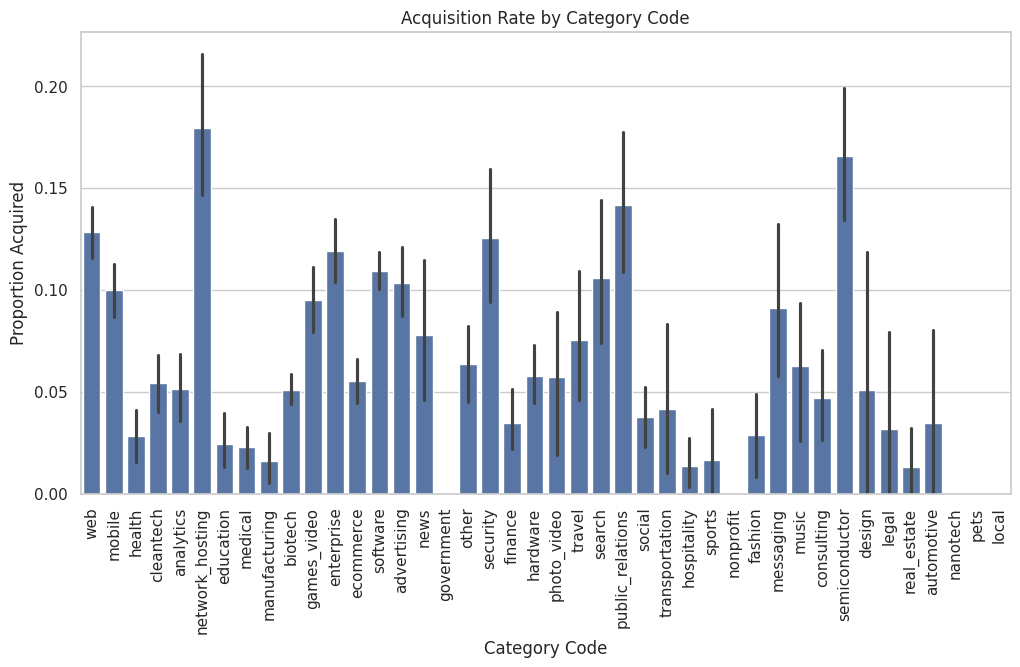

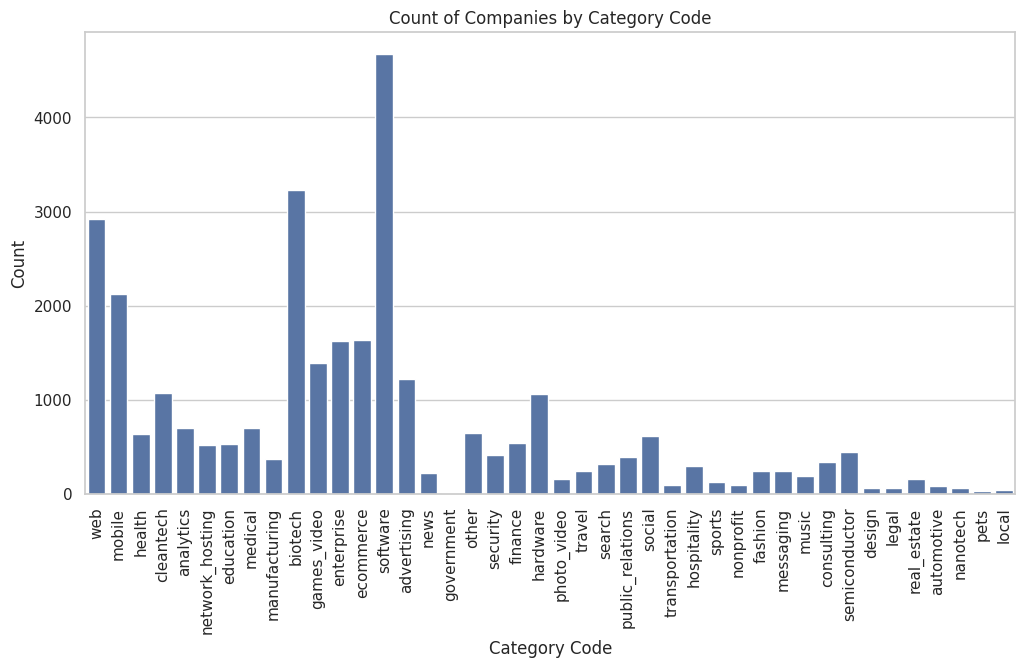

In [31]:
# Bar plot: Acquisition rate by category
plt.figure(figsize=(12, 6))
sns.barplot(x='category_code', y='is_acquired', data=df_crunchbase)
plt.xticks(rotation=90)
plt.title("Acquisition Rate by Category Code")
plt.xlabel("Category Code")
plt.ylabel("Proportion Acquired")
plt.show()

# Count plot: Number of companies per category
plt.figure(figsize=(12, 6))
sns.countplot(x='category_code', data=df_crunchbase)
plt.xticks(rotation=90)
plt.title("Count of Companies by Category Code")
plt.xlabel("Category Code")
plt.ylabel("Count")
plt.show()


- The top categories based on the proportion of successful acquisitions are "network_hosting", "design" and "public_relations".
- The top categories based on the count of companies in them are "software", "biotech" and "web".

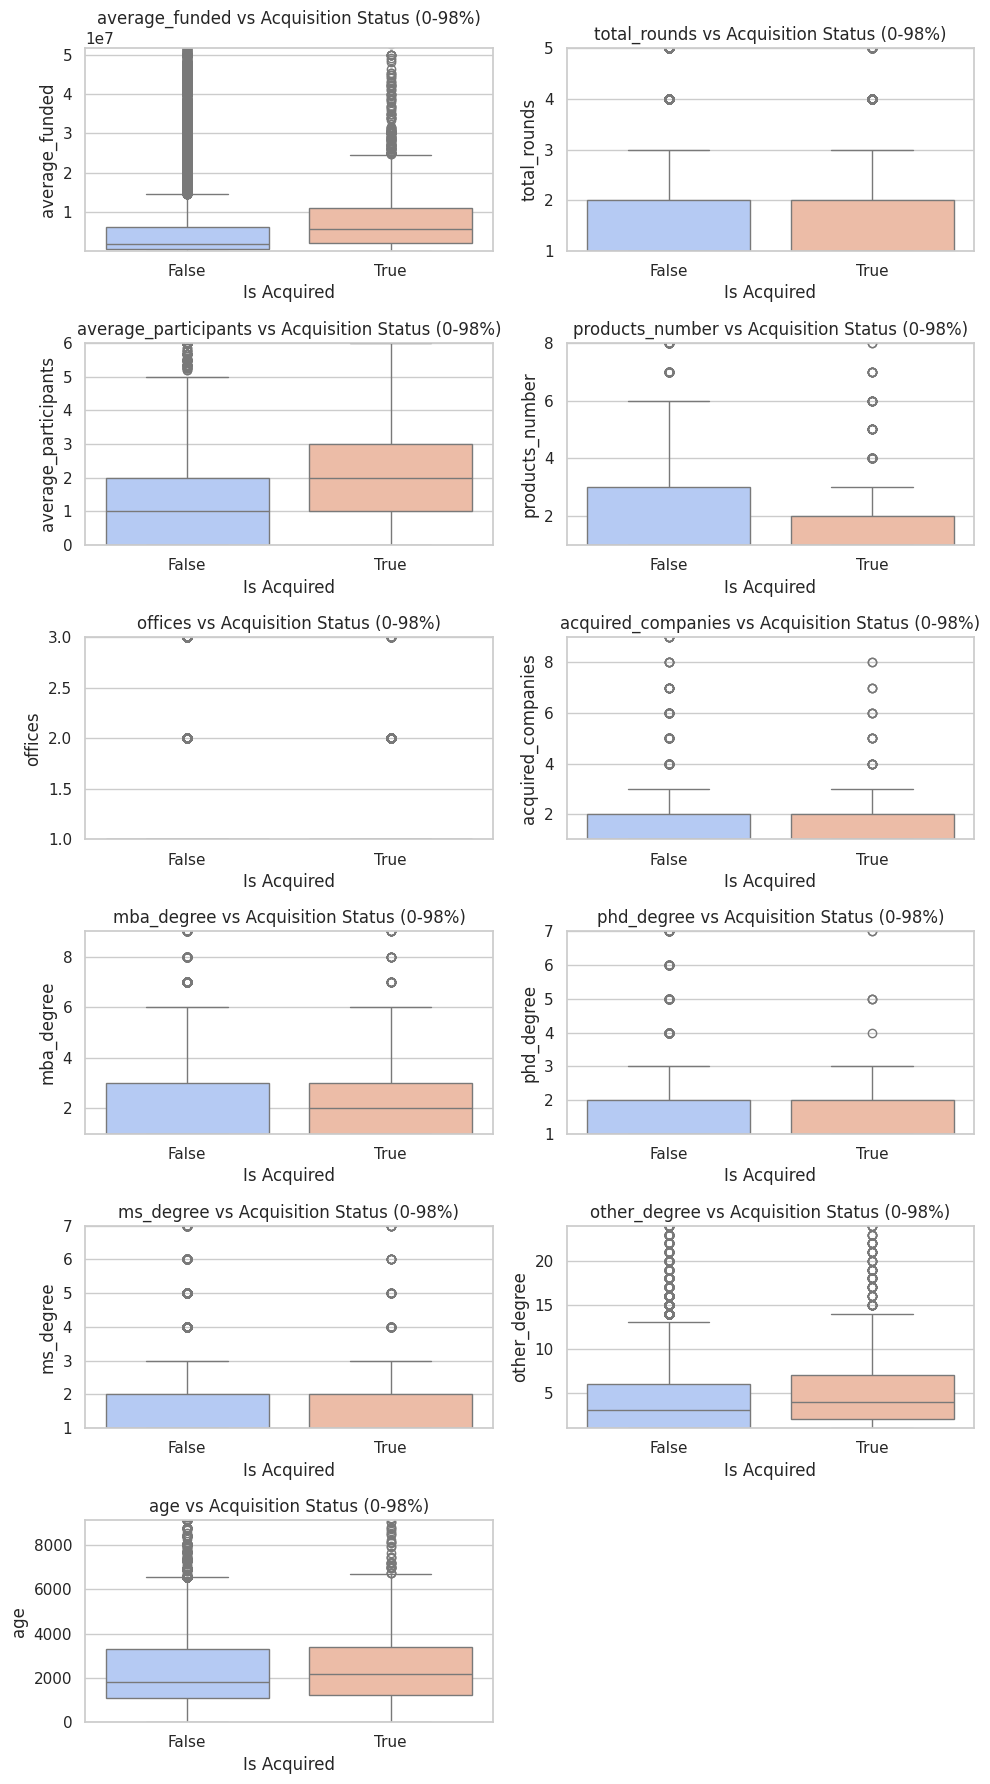

In [32]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))
axes = axes.flatten()

# Loop through numerical columns and create plots
for i, col in enumerate(numerical_cols):
    lower_bound = df_crunchbase[col].min()
    upper_bound = df_crunchbase[col].quantile(0.98)  # 98th percentile

    ax = sns.boxplot(ax=axes[i], x="is_acquired", y=df_crunchbase[col],
                     data=df_crunchbase, hue="is_acquired", palette="coolwarm")

    axes[i].set_ylim(lower_bound, upper_bound)
    axes[i].set_title(f"{col} vs Acquisition Status (0-98%)")
    axes[i].set_xlabel("Is Acquired")
    axes[i].set_ylabel(col)

    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Hide extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Acquired companies on average received higher funding than non-acquired companies.
- Acquired companies have higher number of participants than non-acquired companies.

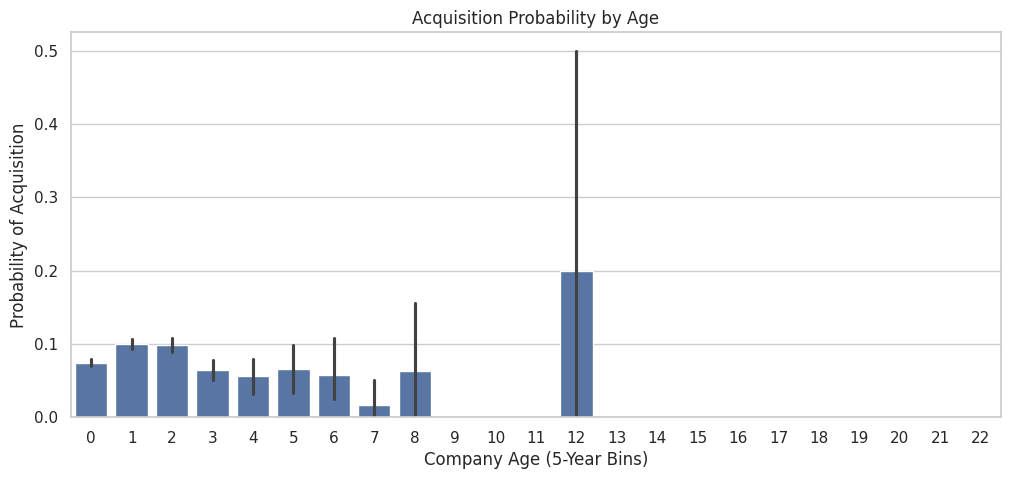

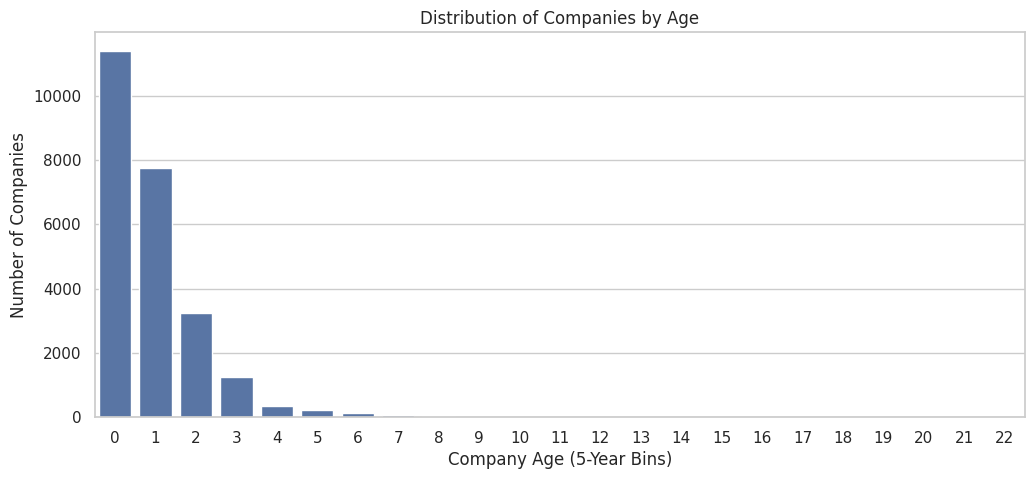

In [33]:
# Convert age to 5-year bins
age_acquisition = df_crunchbase[['age', 'is_acquired']].dropna().copy()
age_acquisition['age'] = (age_acquisition['age'] // (365 * 5)).astype(int)

# Bar plot: Acquisition probability by age
plt.figure(figsize=(12, 5))
sns.barplot(x='age', y='is_acquired', data=age_acquisition)
plt.title('Acquisition Probability by Age')
plt.xlabel('Company Age (5-Year Bins)')
plt.ylabel('Probability of Acquisition')
plt.show()

# Count plot: Number of companies in each age group
print("\n")
plt.figure(figsize=(12, 5))
sns.countplot(x='age', data=age_acquisition[age_acquisition['age'].notnull()])
plt.title('Distribution of Companies by Age')
plt.xlabel('Company Age (5-Year Bins)')
plt.ylabel('Number of Companies')
plt.show()

- Acquisition probability is highest for older companies (~60 years old).
- Most companies are relatively young, as observed from the numerical summary statistics.

### Multivariate Analysis

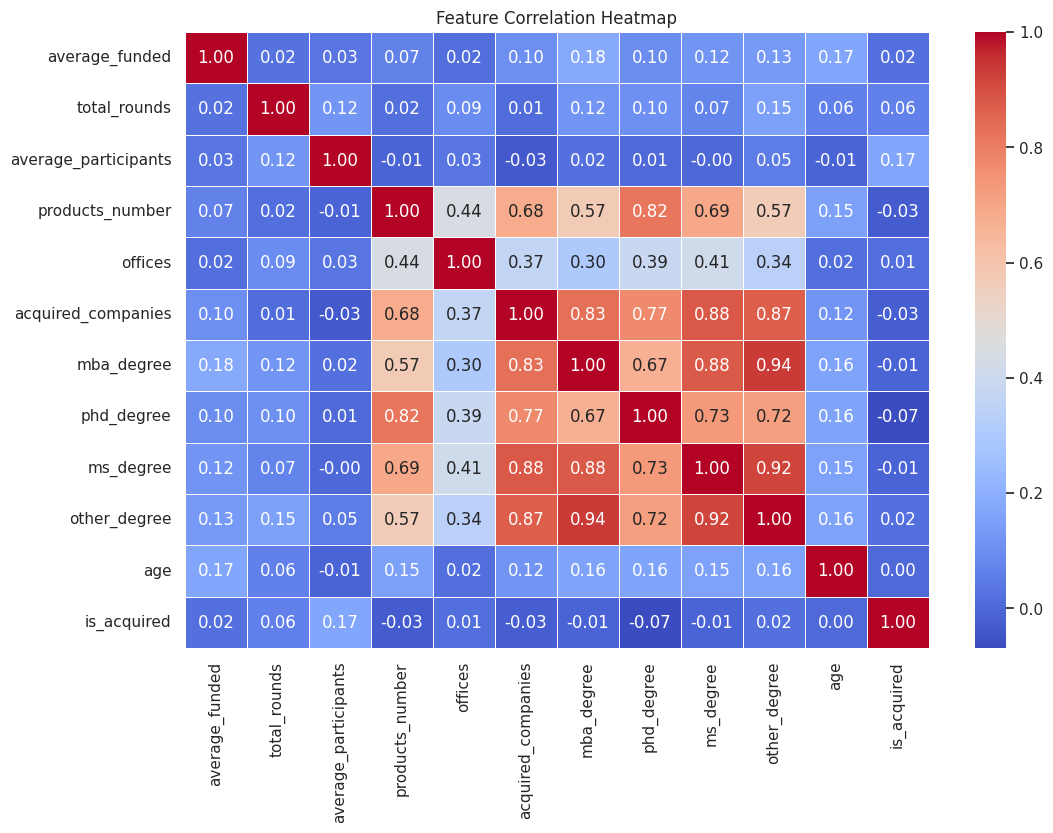

In [34]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_crunchbase[numerical_cols + ["is_acquired"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

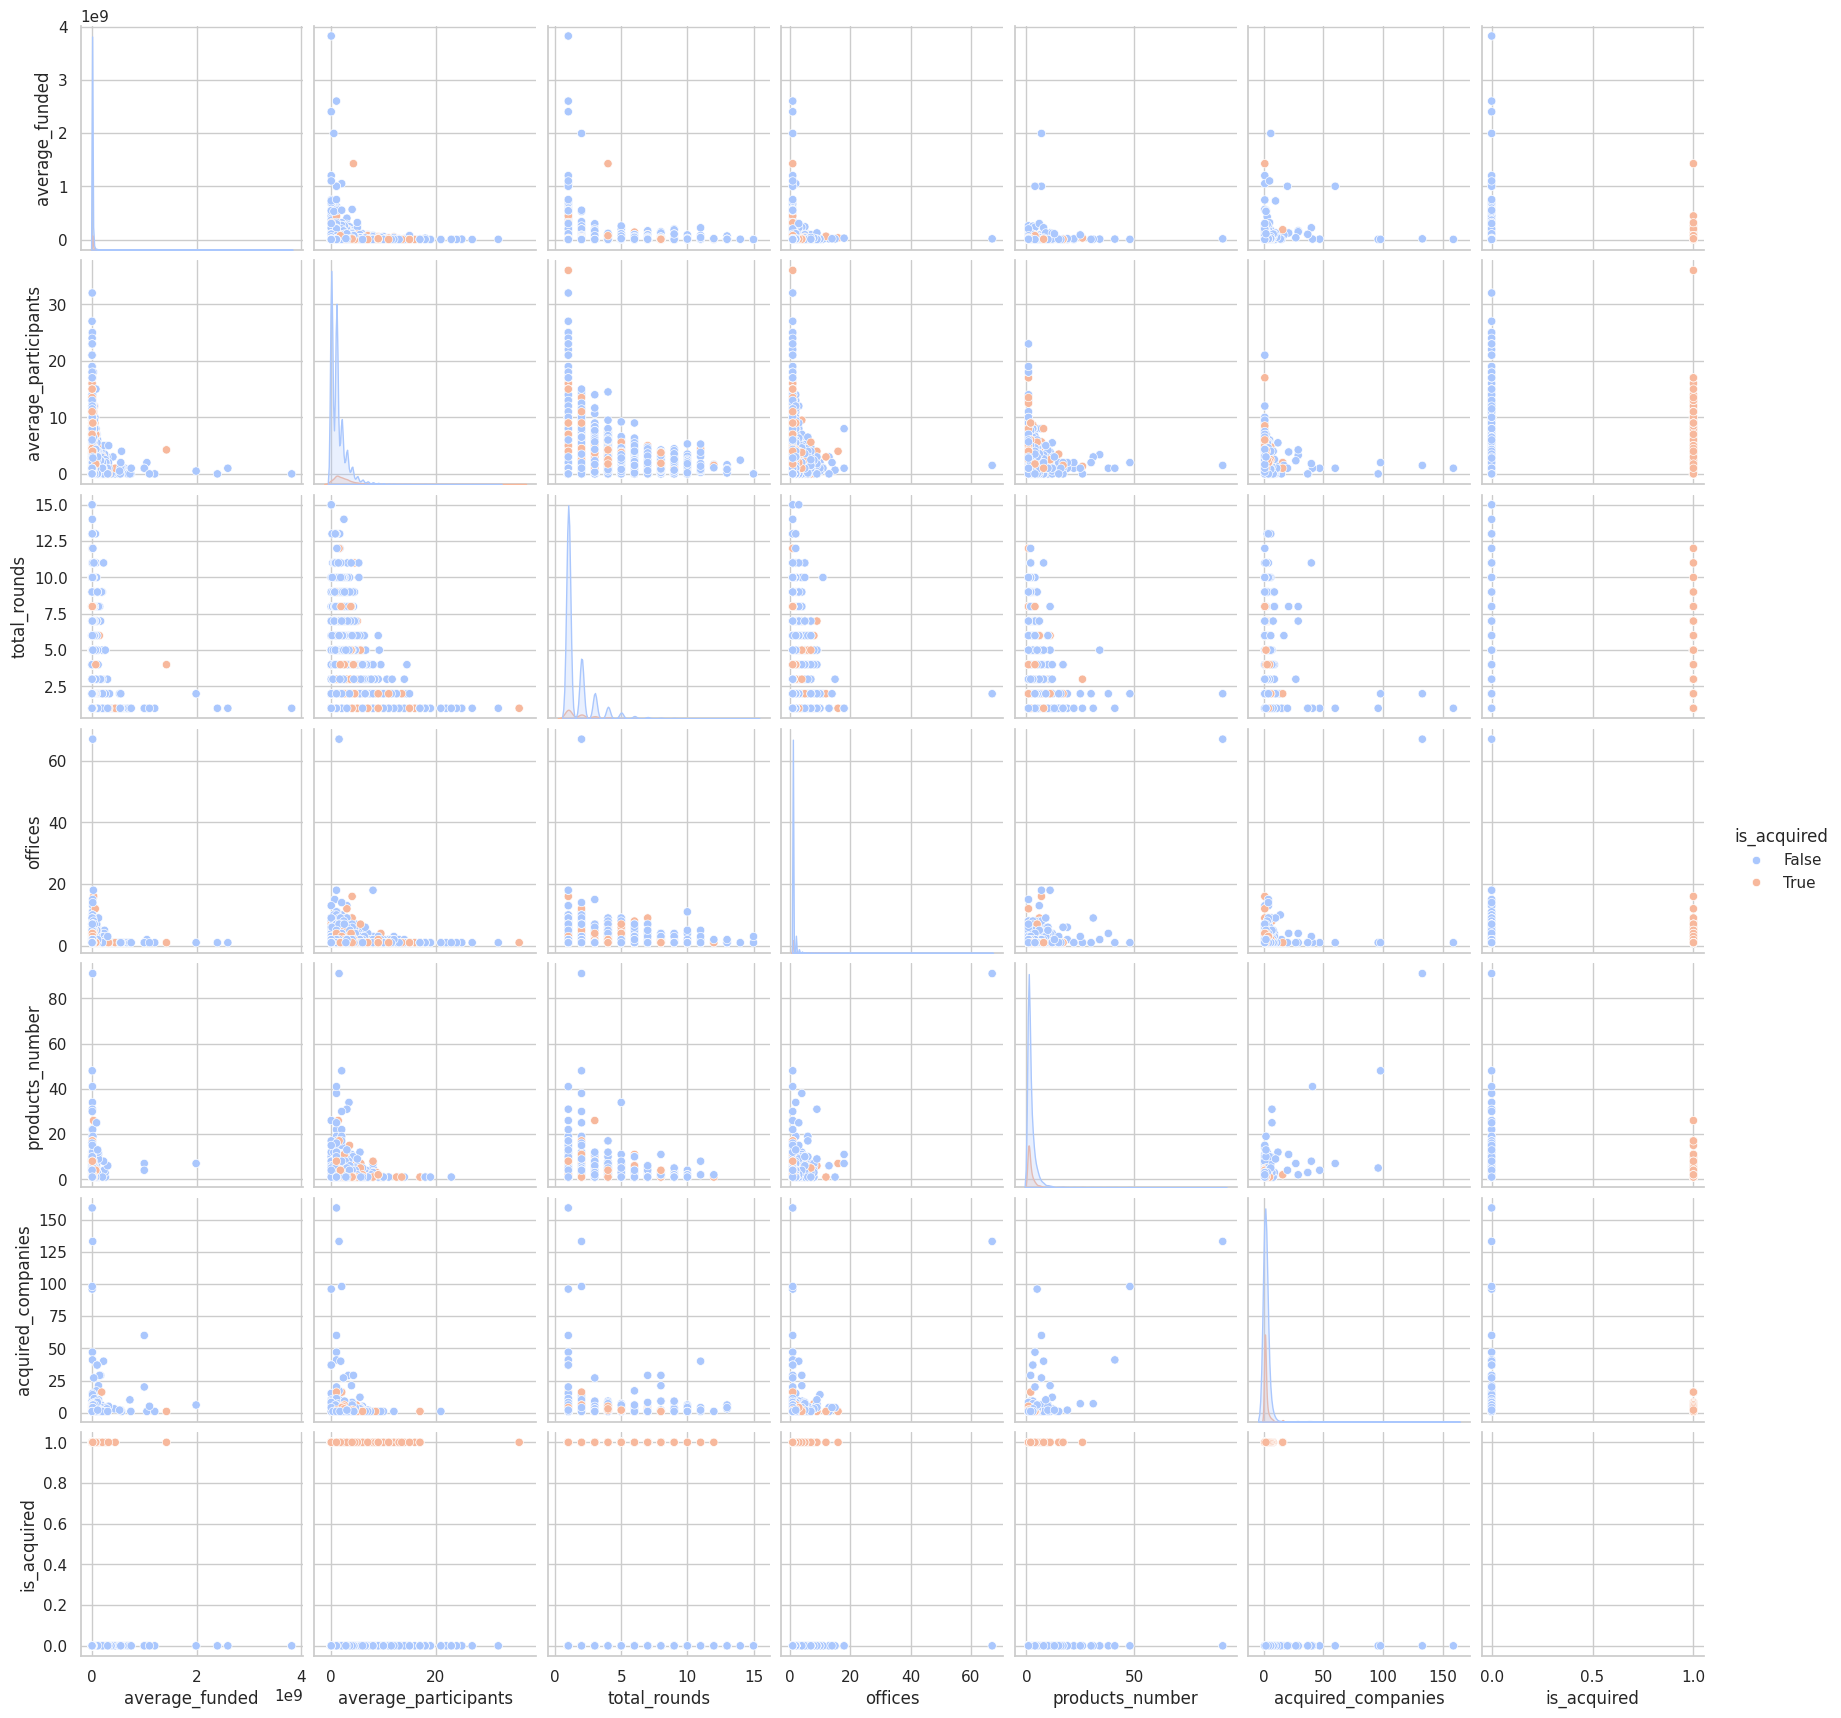

In [35]:
# Pair Plot
columns = ['average_funded', 'average_participants', 'total_rounds', 'offices',
                    'products_number', 'acquired_companies','is_acquired']
sns.pairplot(df_crunchbase, hue="is_acquired", vars=columns, palette="coolwarm")
plt.show()

### Conclusions

1. Funding & Investment Trends  
  - Funding distribution is highly skewed, with an average funding amount of 8.12M USD, but 75% of companies received 6.70M USD or less, indicating that most startups operate with relatively low funding.  
  - Acquired companies tend to receive higher funding on average than non-acquired companies, suggesting that higher funding may increase the likelihood of acquisition.  
  - Most companies have only one funding round, with 75% of startups securing no more than two rounds, while a few companies have reached up to 15 funding rounds.  

2. Acquisition & IPO Insights  
  - Acquisitions are relatively rare, with only 8.23% of companies in the dataset being acquired, highlighting the challenges of achieving a successful exit.  
  - Very few companies go public, with only approximately 300 out of 32,000 having an IPO, indicating that acquisitions are a more common exit strategy than IPOs.  
  - The probability of acquisition is highest for older companies, particularly those around 60 years old, although the majority of companies in the dataset are relatively young, with 75% being nine years old or younger.  

3. Industry & Market Positioning  
  - The software industry dominates the dataset, with 4,677 companies, followed by the biotech and web industries.  
  - The industries with the highest proportion of acquisitions include network hosting, design, and public relations, indicating strong investor interest in these sectors.  
  - Over 60% of companies are based in the United States, with a significant portion located in California, reinforcing the region's position as a major hub for startups.  

4. Growth & Scalability Factors  
  - Acquired companies generally have larger teams and a higher number of participants compared to non-acquired companies.  
  - Most companies operate with a single office, with 75% of companies having just one location, although some have expanded significantly, with a maximum of 67 offices.  
  - Few companies have multiple products, with a median of one product per company, while some companies have up to 91 products, indicating a significant variation in scalability strategies.  

5. Human Capital & Talent Investment  
  - The level of education among employees varies widely, with a median of one MBA, PhD, or MS graduate per company, while some companies have significantly higher numbers, with up to 207 MBAs, 60 PhDs, and 196 MS graduates.  
  - The impact of educational background on acquisition likelihood requires further analysis, as companies with a higher concentration of advanced degrees may have a competitive advantage in securing acquisitions.  


# Crunchbase Dataset ML Modeling

## Data Preprocessing


We first handle the missing values. For this we drop columns with over 50% missing values, impute the nulls of the categorical columns with category "unknown", and impute the nulls of the numerical columns with the median of that column. We also perform one-hot encoding to use categorical features in the ML model training.

In [36]:
df_processed = df_crunchbase.copy()

# Dropping columns with more than 50% missing values
missing_threshold = 0.50
missing_percent = df_processed.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

df_processed.drop(columns=cols_to_drop, inplace=True)
df_processed.drop(columns=["company_id"], inplace=True) # As company id isn't an independent variable

# Filling missing categorical values with "unknown"
categorical_cols = df_processed.select_dtypes(include=["object"]).columns.tolist()
df_processed[categorical_cols] = df_processed[categorical_cols].fillna("unknown")

# Impute missing numerical values with median (robust against outliers)
numerical_cols = df_processed.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_imputer = SimpleImputer(strategy="median")
df_processed[numerical_cols] = num_imputer.fit_transform(df_processed[numerical_cols])

# Apply one-hot encoding to categorical variables
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

In [37]:
print(f"Final dataset shape: {df_processed.shape}")
print(f"Remaining missing values:\n{df_processed.isnull().sum().sum()}")

Final dataset shape: (31984, 53)
Remaining missing values:
0


We now split the dataset into train and test data, and also separate the predictor variables from the response variable. We then use standard scaler to scale the features.

In [38]:
X = df_processed.drop(columns=["is_acquired"])  # Features
y = df_processed["is_acquired"] # Target

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the data for Logistic Regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Resampling Techniques

In this section we experiment with 5 different resampling techniques and evaluate the performance using a simple logistic regression model. We then choose the best resampling technique for our purpose to proceed experimenting with different models.

In [39]:
# Define resampling techniques
resampling_methods = {
    "Original": (X_train, y_train),
    "SMOTE": SMOTE(random_state=42).fit_resample(X_train, y_train),
    "Random Over-Sampling": RandomOverSampler(random_state=42).fit_resample(X_train, y_train),
    "Random Under-Sampling": RandomUnderSampler(random_state=42).fit_resample(X_train, y_train),
    "SMOTE + Tomek Links": SMOTETomek(random_state=42).fit_resample(X_train, y_train),
    "SMOTE + ENN": SMOTEENN(random_state=42).fit_resample(X_train, y_train),
}

results = []

# Train & evaluate Logistic Regression for each resampling method
for method, (X_resampled, y_resampled) in resampling_methods.items():
    # Train Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

    # Compute evaluation metrics
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    auc_roc = roc_auc_score(y_test, y_proba)

    # Store results
    results.append({"Method": method, "F1-Score": f1, "Precision": precision, "Recall": recall, "AUC-ROC": auc_roc})


In [40]:
# Convert results to a DataFrame and sort by AUC-ROC
results_df = pd.DataFrame(results).sort_values(by="AUC-ROC", ascending=False)

# Display the results
display(results_df)

Method  F1-Score  Precision    Recall   AUC-ROC
5            SMOTE + ENN  0.263875   0.159887  0.754753  0.757404
4    SMOTE + Tomek Links  0.272627   0.169188  0.701521  0.751667
1                  SMOTE  0.273739   0.170046  0.701521  0.751510
2   Random Over-Sampling  0.266088   0.164286  0.699620  0.749431
3  Random Under-Sampling  0.270190   0.167978  0.690114  0.749390
0               Original  0.025641   0.350000  0.013308  0.740217

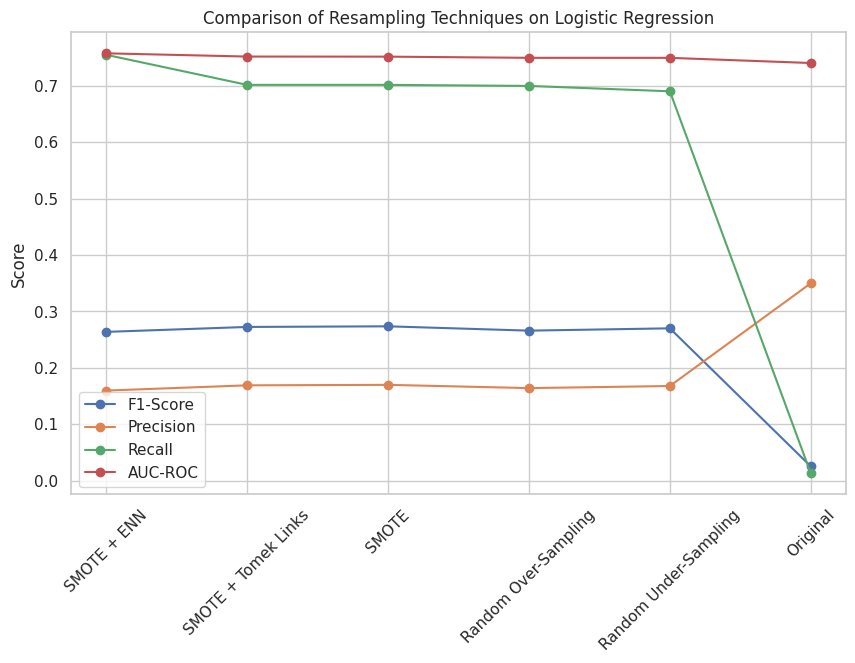

In [41]:
# Plot the results
plt.figure(figsize=(10, 6))
for metric in ["F1-Score", "Precision", "Recall", "AUC-ROC"]:
    plt.plot(results_df["Method"], results_df[metric], marker='o', label=metric)

plt.xticks(rotation=45)
plt.ylabel("Score")
plt.title("Comparison of Resampling Techniques on Logistic Regression")
plt.legend()
plt.show()

- We choose SMOTE + ENN as our chosen resampling technique as it has best AUC-ROC score, Highest Recall and Comparable Precision values.

In [42]:
# Apply SMOTE + ENN only on the training set
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Keep the test set unchanged
X_test_resampled, y_test_resampled = X_test, y_test

# Check class distributions after resampling
print("Class distribution in training set after SMOTE + ENN:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

print("\nClass distribution in test set (unchanged):")
print(pd.Series(y_test_resampled).value_counts(normalize=True))

Class distribution in training set after SMOTE + ENN:
is_acquired
True     0.526365
False    0.473635
Name: proportion, dtype: float64

Class distribution in test set (unchanged):
is_acquired
False    0.917774
True     0.082226
Name: proportion, dtype: float64


## Model Building and Evaluation

In [43]:
# Function definition to check the performance of a model on train data
def calculate_performance_traindata(model_name, y_train, y_train_pred, train_pred_prob):
    '''
    model_name: Name of the model for identification
    y_train: True labels for the training set
    y_train_pred: Predicted labels for the training set
    train_pred_prob: Predicted probabilities for the training set
    '''

    print(f"{model_name} (Train Data):\n")

    # Calculate and print precision
    precision = metrics.precision_score(y_train, y_train_pred)
    print(f"Precision: {precision:.4f}")

    # Calculate and print recall
    recall = metrics.recall_score(y_train, y_train_pred)
    print(f"Recall: {recall:.4f}")

    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_train, y_train_pred)
    print(f"F1 Score: {f1_score:.4f}")

    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_train, train_pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Train"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })

In [44]:
# Function definition to check the performance of a model on test data

def calculate_performance_testdata(model_name, y_test, y_pred, pred_prob):
    '''
    model_name: Name of the model for identification
    y_test: True labels for the test set
    y_pred: Predicted labels for the test set
    pred_prob: Predicted probabilities for the test set
    '''

    print(f"{model_name} (Test Data):\n")

    # Calculate and print precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")

    # Calculate and print recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")

    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_test, y_pred)
    print(f"F1 Score: {f1_score:.4f}")

    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_test, pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Test"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })


### Logistic Regression

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn import metrics

In [46]:
# Building logistic regression model
log = LogisticRegression()
log_model = log.fit(X_train_resampled, y_train_resampled)

# Making predictions on the training data
y_train_pred = log_model.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob = log_model.predict_proba(X_train_resampled)

# Evaluating the model on the training data
train_performance_df = calculate_performance_traindata("Logistic Regression", y_train_resampled, y_train_pred, train_pred_prob[:, 1])

# Display the performance metrics for the training data
display(train_performance_df)

Logistic Regression (Train Data):

Precision: 0.7803
Recall: 0.8003
F1 Score: 0.7902
ROC AUC: 0.8547
Accuracy: 0.7763



Model  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression-Train   0.780319  0.800344  0.790205  0.854704   

   Accuracy  
0  0.776308

In [47]:
# Making predictions on the test data
y_test_pred = log_model.predict(X_test)

# Checking predict probability on PCA data for the test data
test_pred_prob = log_model.predict_proba(X_test)

# Evaluating the model on the test data
test_performance_df = calculate_performance_testdata("Logistic Regression", y_test, y_test_pred, test_pred_prob[:, 1])

# Displaying the performance metrics for the test data
display(test_performance_df)

Logistic Regression (Test Data):

Precision: 0.1599
Recall: 0.7548
F1 Score: 0.2639
ROC AUC: 0.7574
Accuracy: 0.6537



Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Logistic Regression-Test   0.159887  0.754753  0.263875  0.757404  0.653744

#### Optimal Probability Threshold

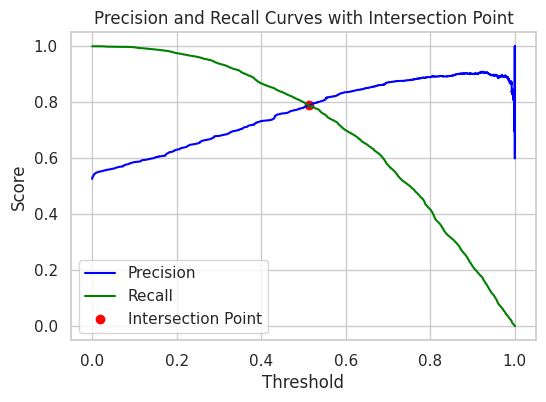

Intersection Threshold: 0.5126


In [48]:
# Predict probabilities on the training set
y_prob = log_model.predict_proba(X_train_resampled)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_train_resampled, y_prob)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Find the threshold where precision and recall intersect
intersection_threshold = thresholds[np.argmax(precision >= recall)]

# Plot precision and recall curves
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.scatter(intersection_threshold, precision[np.argmax(precision >= recall)], color='red', marker='o', label='Intersection Point')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves with Intersection Point')
plt.legend()
plt.show()

print(f"Intersection Threshold: {intersection_threshold:.4f}")

In [49]:
# Update training predictions using the optimal threshold
y_train_prob = log_model.predict_proba(X_train_resampled)[:, 1]
y_train_pred_final = (y_train_prob >= intersection_threshold).astype(int)

# Making predictions on the test data (using probabilities)
y_test_prob = log_model.predict_proba(X_test)[:, 1]
y_test_pred_final = (y_test_prob >= intersection_threshold).astype(int)


# Evaluating the model on the training data
train_performance_df_final = calculate_performance_traindata("Logistic Regression (Final)",
                                                              y_train_resampled,
                                                              y_train_pred_final,
                                                              y_train_prob)

# Display the performance metrics for the training data
print("\nFinal Training Performance Metrics:")
display(train_performance_df_final)

# Evaluating the model on the test data
test_performance_df_final = calculate_performance_testdata("Logistic Regression (Final)",
                                                            y_test,
                                                            y_test_pred_final,
                                                            y_test_prob)

# Display the performance metrics for the test data
print("\nFinal Test Performance Metrics:")
display(test_performance_df_final)

Logistic Regression (Final) (Train Data):

Precision: 0.7888
Recall: 0.7888
F1 Score: 0.7888
ROC AUC: 0.8547
Accuracy: 0.7776


Final Training Performance Metrics:


Model  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression (Final)-Train   0.788777  0.788777  0.788777  0.854704   

   Accuracy  
0  0.777639

Logistic Regression (Final) (Test Data):

Precision: 0.1646
Recall: 0.7433
F1 Score: 0.2695
ROC AUC: 0.7574
Accuracy: 0.6686


Final Test Performance Metrics:


Model  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression (Final)-Test   0.164562  0.743346  0.269469  0.757404   

   Accuracy  
0  0.668595

### Random Forest

In [50]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, max_depth=3)
rf.fit(X_train_resampled, y_train_resampled)

# Making predictions on the training data
y_train_pred_rf = rf.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_rf = rf.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_rf = calculate_performance_traindata(
    "Random Forest", y_train_resampled, y_train_pred_rf, train_pred_prob_rf
)

# Display the performance metrics for the training data
display(train_performance_rf)

Random Forest (Train Data):

Precision: 0.7931
Recall: 0.8445
F1 Score: 0.8180
ROC AUC: 0.8771
Accuracy: 0.8022



Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Random Forest-Train   0.793138  0.844515  0.818021  0.877086   0.80222

In [51]:
# Making predictions on the test data
y_test_pred_rf = rf.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_rf = calculate_performance_testdata(
    "Random Forest", y_test, y_test_pred_rf, test_pred_prob_rf
)

# Display the performance metrics for the test data
display(test_performance_rf)

Random Forest (Test Data):

Precision: 0.1586
Recall: 0.7205
F1 Score: 0.2599
ROC AUC: 0.7468
Accuracy: 0.6627



Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Random Forest-Test   0.158577  0.720532  0.259945  0.746782  0.662654

#### Hyperparameter Tuning

In [52]:
# Define the parameter grid for randomized search
param_dist = {
    "n_estimators": [10, 25, 50, 75],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring="recall",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Fit the random search to the data
random_search_recall.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}


In [53]:
# Train a tuned RandomForestClassifier with the best parameters
rf_tuned = RandomForestClassifier(random_state=42, **random_search_recall.best_params_)
rf_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=25,
                       random_state=42)

In [54]:
# Making predictions on the training data
y_train_pred_rf_tuned = rf_tuned.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_rf_tuned = rf_tuned.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_rf_tuned = calculate_performance_traindata(
    "Random Forest (Tuned)", y_train_resampled, y_train_pred_rf_tuned, train_pred_prob_rf_tuned
)

# Display the performance metrics for the training data
display(train_performance_rf_tuned)

Random Forest (Tuned) (Train Data):

Precision: 0.8066
Recall: 0.8816
F1 Score: 0.8424
ROC AUC: 0.9044
Accuracy: 0.8264



Model  Precision    Recall  F1 Score   ROC AUC  \
0  Random Forest (Tuned)-Train   0.806596  0.881584  0.842425  0.904395   

   Accuracy  
0  0.826405

In [55]:
# Making predictions on the test data
y_test_pred_rf_tuned = rf_tuned.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_rf_tuned = calculate_performance_testdata(
    "Random Forest (Tuned)", y_test, y_test_pred_rf_tuned, test_pred_prob_rf_tuned
)

# Display the performance metrics for the test data
display(test_performance_rf_tuned)

Random Forest (Tuned) (Test Data):

Precision: 0.1618
Recall: 0.7338
F1 Score: 0.2651
ROC AUC: 0.7601
Accuracy: 0.6655



Model  Precision   Recall  F1 Score  ROC AUC  Accuracy
0  Random Forest (Tuned)-Test   0.161777  0.73384   0.26511  0.76011  0.665468

### Gradient Boosting

In [56]:
# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42, subsample=0.8)
gb.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42, subsample=0.8)

In [57]:
# Get model parameters
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [58]:
# Making predictions on the training data
y_train_pred_gb = gb.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_gb = gb.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_gb = calculate_performance_traindata(
    "Gradient Boosting", y_train_resampled, y_train_pred_gb, train_pred_prob_gb
)

# Display the performance metrics for the training data
display(train_performance_gb)

Gradient Boosting (Train Data):

Precision: 0.8774
Recall: 0.9174
F1 Score: 0.8970
ROC AUC: 0.9616
Accuracy: 0.8891



Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Gradient Boosting-Train   0.877431  0.917415  0.896978  0.961649  0.889075

In [59]:
# Making predictions on the test data
y_test_pred_gb = gb.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_gb = gb.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_gb = calculate_performance_testdata(
    "Gradient Boosting", y_test, y_test_pred_gb, test_pred_prob_gb
)

# Display the performance metrics for the test data
display(test_performance_gb)

Gradient Boosting (Test Data):

Precision: 0.1945
Recall: 0.6578
F1 Score: 0.3002
ROC AUC: 0.7845
Accuracy: 0.7479



Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Gradient Boosting-Test   0.194491  0.657795  0.300217  0.784489  0.747851

In [60]:
# Define the parameter grid for randomized search
param_dist = {
    "n_estimators": [25, 50, 75, 100],
    "learning_rate": [0.01, 0.03, 0.04, 0.05],
    "max_depth": [2, 3, 5],
}

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

# Fit the random search to the data
random_search_recall_gb.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_gb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 25, 'max_depth': 3, 'learning_rate': 0.01}


In [61]:
# Train a tuned GradientBoostingClassifier with the best parameters
gb_tuned = GradientBoostingClassifier(
    random_state=42, **random_search_recall_gb.best_params_, subsample=0.8
)
gb_tuned.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=25, random_state=42,
                           subsample=0.8)

In [62]:
# Making predictions on the training data
y_train_pred_gb_tuned = gb_tuned.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_gb_tuned = gb_tuned.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_gb_tuned = calculate_performance_traindata(
    "Gradient Boosting (Tuned)", y_train_resampled, y_train_pred_gb_tuned, train_pred_prob_gb_tuned
)

# Display the performance metrics for the training data
display(train_performance_gb_tuned)

Gradient Boosting (Tuned) (Train Data):

Precision: 0.7429
Recall: 0.9242
F1 Score: 0.8237
ROC AUC: 0.8652
Accuracy: 0.7918



Model  Precision    Recall  F1 Score   ROC AUC  \
0  Gradient Boosting (Tuned)-Train    0.74294  0.924248  0.823735  0.865225   

   Accuracy  
0  0.791799

In [63]:
# Making predictions on the test data
y_test_pred_gb_tuned = gb_tuned.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_gb_tuned = gb_tuned.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_gb_tuned = calculate_performance_testdata(
    "Gradient Boosting (Tuned)", y_test, y_test_pred_gb_tuned, test_pred_prob_gb_tuned
)

# Display the performance metrics for the test data
display(test_performance_gb_tuned)

Gradient Boosting (Tuned) (Test Data):

Precision: 0.1336
Recall: 0.7795
F1 Score: 0.2282
ROC AUC: 0.7273
Accuracy: 0.5664



Model  Precision    Recall  F1 Score   ROC AUC  \
0  Gradient Boosting (Tuned)-Test   0.133638  0.779468  0.228158  0.727256   

   Accuracy  
0  0.566359

### Model Comparison

In [64]:
# Creating DataFrames for performance metrics
train_performance_df_log = pd.DataFrame(train_performance_df_final, index=[0])
test_performance_df_log = pd.DataFrame(test_performance_df_final, index=[0])
train_performance_df_rf = pd.DataFrame(train_performance_rf_tuned, index=[0])
test_performance_df_rf = pd.DataFrame(test_performance_rf_tuned, index=[0])
train_performance_df_gb = pd.DataFrame(train_performance_gb_tuned, index=[0])
test_performance_df_gb = pd.DataFrame(test_performance_gb_tuned, index=[0])

# Concatenate the DataFrames with appropriate keys
combined_performance_df = pd.concat(
    [
        train_performance_df_log, test_performance_df_log,
        train_performance_df_rf, test_performance_df_rf,
        train_performance_df_gb, test_performance_df_gb
    ],
    keys=['Train_Log', 'Test_Log', 'Train_RF', 'Test_RF', 'Train_GB', 'Test_GB']
)

# Display the combined performance metrics
combined_performance_df_reset = combined_performance_df.reset_index(drop=True)
display(combined_performance_df_reset)


Model  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression (Final)-Train   0.788777  0.788777  0.788777  0.854704   
1   Logistic Regression (Final)-Test   0.164562  0.743346  0.269469  0.757404   
2        Random Forest (Tuned)-Train   0.806596  0.881584  0.842425  0.904395   
3         Random Forest (Tuned)-Test   0.161777  0.733840  0.265110  0.760110   
4    Gradient Boosting (Tuned)-Train   0.742940  0.924248  0.823735  0.865225   
5     Gradient Boosting (Tuned)-Test   0.133638  0.779468  0.228158  0.727256   

   Accuracy  
0  0.777639  
1  0.668595  
2  0.826405  
3  0.665468  
4  0.791799  
5  0.566359

- Logistic Regression (Final) performs well on training data (Precision: 0.79, ROC AUC: 0.85), but its test precision drops significantly to 0.16, indicating potential overfitting.
- Random Forest (Tuned) achieves the highest ROC AUC on test data (0.76) and has a balanced recall (0.73), making it a strong performer.
- Gradient Boosting (Tuned) has the highest recall on test data (0.78) but suffers from low precision (0.13) and accuracy (0.57), making it unreliable.

Best Model:
- Random Forest (Tuned) is the best model as it provides the best overall test performance (AUC-ROC: 0.76, Recall: 0.73, and a reasonable tradeoff between precision and recall).

### Feature Importance

In [67]:
# Get feature importances
feature_importances = rf_tuned.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("Top Feature Importances:")
display(feature_importance_df.head(10))

Top Feature Importances:


Feature  Importance
2    average_participants    0.363332
0          average_funded    0.248806
1            total_rounds    0.095762
51       state_code_other    0.076515
5               is_closed    0.045445
6                     age    0.035841
49       country_code_USA    0.032045
50     country_code_other    0.029614
48      category_code_web    0.022992
26  category_code_medical    0.008896

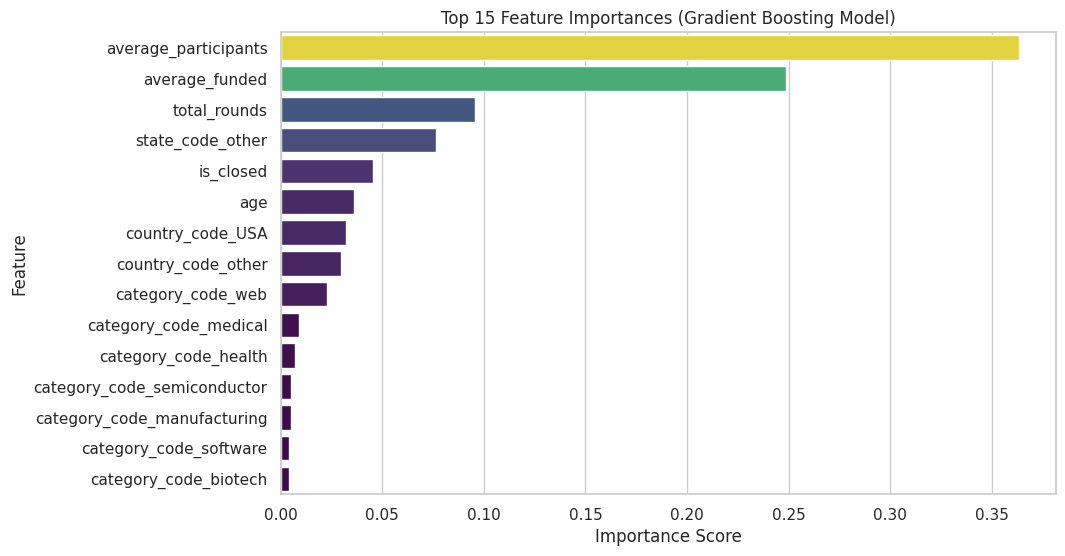

In [68]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df[:15]["Importance"], y=feature_importance_df[:15]["Feature"], hue=feature_importance_df[:15]["Importance"], palette="viridis", legend = False)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Gradient Boosting Model)")
plt.show()

- Funding, team size, and location are the strongest predictors of acquisition, while company status and industry also play a role.